<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/%EA%B3%BC%EC%A0%9C/%EC%A0%9C%EC%B6%9C%EC%9E%90%EB%A3%8C(%EC%B5%9C%EC%A2%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 팀소개: 네모시

<<이런 저런 내용들>>

# [요약] 주요 포인트

<<이런 저런 내용들>>

# 준비단계

## Google Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## train, test 파일 다운로드

In [ ]:
!gdown 1F6Otr01l-sUUR_1AdTM925tAGDE_L--t
!gdown 13lNIGs3wsD0mZF4OauV4GhZQHniNjK6d

Downloading...
From: https://drive.google.com/uc?id=1F6Otr01l-sUUR_1AdTM925tAGDE_L--t
To: /content/train.csv
100% 3.47M/3.47M [00:00<00:00, 181MB/s]
Downloading...
From: https://drive.google.com/uc?id=13lNIGs3wsD0mZF4OauV4GhZQHniNjK6d
To: /content/test.csv
100% 1.28M/1.28M [00:00<00:00, 46.1MB/s]


## 패키지 설치

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.4 MB/s eta 0:00:00


## 패키지 불러오기

In [ ]:
# Core
import os, math
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from category_encoders.ordinal import OrdinalEncoder

# 분류 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

# utils
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
tqdm.pandas()

## csv 불러오기

In [ ]:
df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# EDA(Exploratory Data Analysis, 탐색적 데이터 분석)

### **EDA란?**
> EDA 혹은 탐색적 데이터 분석이라고도 불리는 이 절차는, 데이터를 살펴보고 뜯어보는 과정에서 반복되는 패턴, 관계, 인사이트를 얻기 위해 필요합니다.
    <br>
    <br>
    이미 잘 아는 분야, 데이터라면 "이렇게 하면 이런 결과가 나올 것이다"라는 가설을 가지고 바로 실험해볼 수도 있지만,
    그렇지 않을 때는 반드시 거쳐야 하는 과정입니다(물론 잘 아는 분야여도 EDA를 통해서 새로운 정보를 얻을 수도 있구요!)
    <br>
    <br>
    코드를 작성해야 하는 일이 늘어나 부담이 될 수는 있지만, 섣불리 건너뛰었다가는 데이터에 대한 이해 부족으로 다시 EDA를 하러 돌아오는 불상사가 발생할 수 있으니,
    조금만 힘내서 EDA를 해보자구요.
    
<br>
<br>

---

##### >> EDA가 궁금하신 분들을 위해, 데이콘에 소개된 양질의 게시글들을 추천해드릴게요!

| URL                                                                                                                                  | 작성자    | 추천사유                                                                                                                                                                                       |
|--------------------------------------------------------------------------------------------------------------------------------------|-----------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| [[EDA] 데이터 분석 입문자를 위한 데이터 살펴보기](https://dacon.io/competitions/official/236147/codeshare/8682)                      | DACONIO   | 데이콘에서 제공하는 EDA baseline 코드입니다.  <br><br> 데이터와 주제는 다르지만, EDA의 필수요소라고 할 수 있는 내용들이  <br>들어가있기 때문에 추천드려요!                                     |
| [[데이썬☀️_3편] 🔍EDA (탐색적 데이터 분석) 사용 설명서 (1) - EDA & 통계치 분석](https://dacon.io/codeshare/4899)                       | 므인      | 기본적인 EDA의 종류와 유형부터 이상치 처리, 결측치와 같은 통계치 분석에 대한 내용도 일목요연하게 정리되어 있습니다. <br><br> 데이터 분석 입문자 분들께는 좋은 참고자료가 될 것이기에 추천드립니다. |
| [ 데이콘의 경진대회 수상작들 중에 PDF로 만들어진 내용을 슬라이드 쉐어에 모아 봤습니다. ](https://dacon.io/forum/409145?dtype=recent) | DATA MONK | 해당 게시글에 시각화 우수 사례들이 많이 소개되어 있습니다.  <br><br> 실제 프로젝트, 대회에서는 어떻게 데이터를 시각화하는지 궁금하다면 꼭 확인해보세요.                                            |

## 데이터 이해

저희 팀은 주어진 데이터가 신용카드 회사에서 고객으로부터 수집한 것이며, 각각의 데이터(row)는 수집일을 기준으로 기재되었음을 가정했습니다.
<br>
<br>
### feature 파악

이에 따라 파악하거나 유추한 각 feature의 의미는 다음과 같습니다.

| feature       | 의미                                              | 비고                             |
|---------------|---------------------------------------------------|----------------------------------|
| gender        |  성별                                             |                                  |
| car           |  차량 소유 여부                                   |                                  |
| realty        |  부동산 소유 여부                                 |                                  |
| child_num     |  자녀 수                                          |                                  |
| income_total  |  연간 소득                                        |                                  |
| income_type   |  소득 분류                                        |                                  |
| edu_type      |  교육 수준                                        |                                  |
| family_type   |  결혼 여부                                        |                                  |
| house_type    |  생활 방식                                        |                                  |
| DAYS_BIRTH    |  출생일                                           | 데이터 수집일 기준 이벤트 발생일 |
| DAYS_EMPLOYED |  업무 시작일                                      | 데이터 수집일 기준 이벤트 발생일 |
| FLAG_MOBIL    |  핸드폰 소유 여부                                 |                                  |
| work_phone    |  업무용 전화 소유 여부                            |                                  |
| phone         |  가정용 전화 소유 여부                            |                                  |
| email         |  이메일 소유 여부                                 |                                  |
| occyp_type    |  직업 유형                                        |                                  |
| family_size   |  가족 규모                                        |                                  |
| begin_month   |  신용카드 발급 월                                 | 데이터 수집일 기준 이벤트 발생일 |
| credit        |  사용자의 신용카드 대금 연체를 기준으로 한 신용도 | 낮을수록 높은 신용도             |

<br>

#### ▶︎ '데이터 수집일 기준 이벤트 발생일'에 대해서

> 'DAYS_BIRTH'의 경우, `수집일 - 생년월일(일 단위)`로 계산되기 때문에 음수의 값을 지닙니다.
  가령 수집일 하루 전에 태어난 사람이 있다면 `-1`로 기재될 것입니다.

## 기본정보 확인

In [ ]:
df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

##### 설명

> 각 feature는 어떤 데이터 타입인지, 결측치는 없는지 출력값에서 확인할 수 있습니다.
    - 총 데이터 수: 출력값 상단의 RangeIndex 확인
    - 결측치 여부: 'RangeIndex'와 'Non-Null Count' 비교
    - 데이터 타입: Dtype 확인 (문자열은 object로 확인)

## 통계치 확인

### 결측치

In [ ]:
df.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

<Axes: >

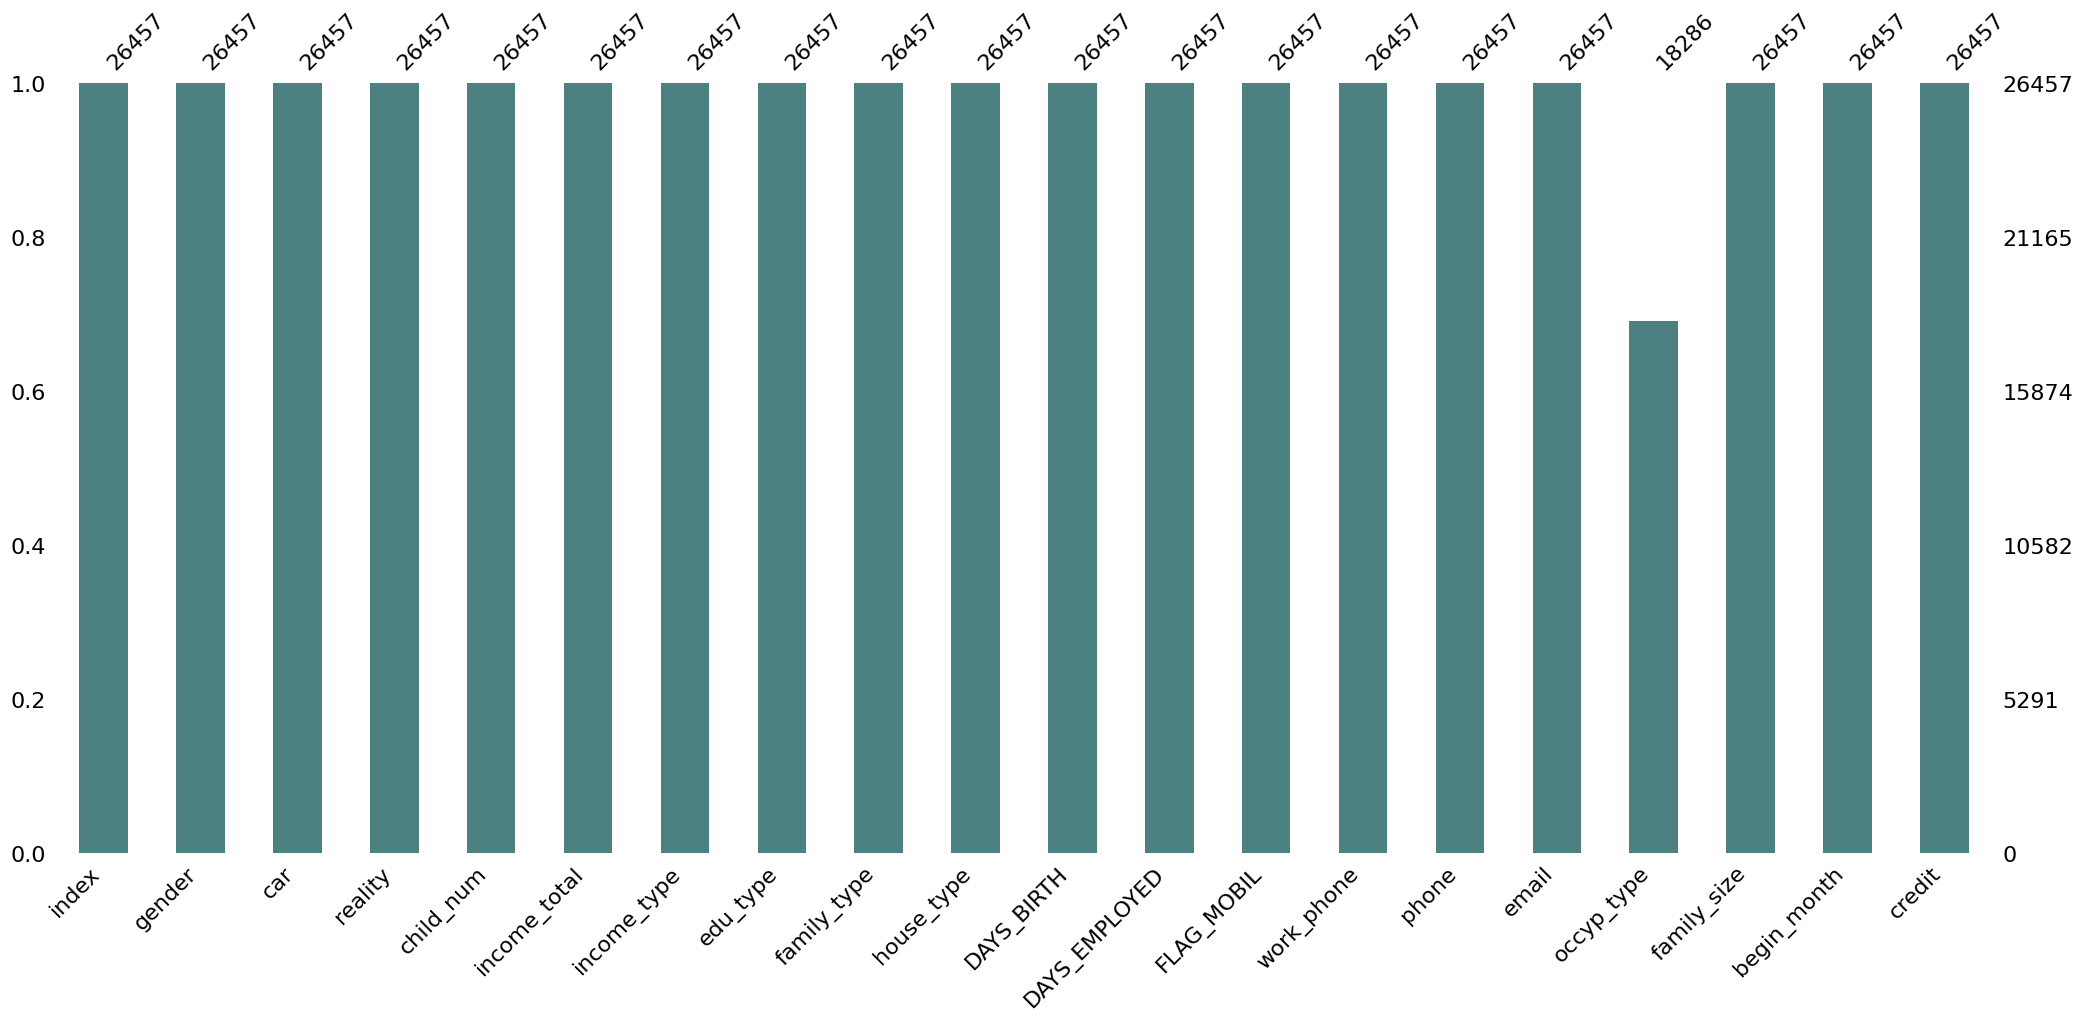

In [ ]:
msno.bar(df=df, color=(0.3, 0.5, 0.5))

##### 설명
결측치는 occyp_type에만 존재함을 확인할 수 있습니다.

### 중복값, 고유값

In [ ]:
print("index를 포함한 중복값 :", df.duplicated().sum())
print("index를 제외한 중복값 :", df.drop(columns = ['index']).duplicated().sum())
print("index, credit을 제외한 중복값 :", df.drop(columns = ['index', 'credit']).duplicated().sum())
print("=" * 50)
print("각 feature별 고유값 확인 :")
display(df.nunique())

index를 포함한 중복값 : 0
index를 제외한 중복값 : 1634
index, credit을 제외한 중복값 : 2353
각 feature별 고유값 확인 :


index            26457
gender               2
car                  2
reality              2
child_num            9
income_total       249
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        6621
DAYS_EMPLOYED     3470
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
occyp_type          18
family_size         10
begin_month         61
credit               3
dtype: int64

##### 설명
index를 제외한 모든 feature가 동일한 데이터가 존재하므로, **동일 인물이 여러 장의 신용카드를 발급했을 가능성**을 고려해야합니다. 또한, 유일값 확인을 통해 FLAG_MOBIL은 모든 값이 동일한, 불필요한 열인 것을 확인할 수 있습니다.

고유값 분포를 더 상세히 살펴봅니다.

In [ ]:
def feature_unique(feature):
    print(f'--- {feature} ---')
    print(f''' {df[feature].nunique()} | {df[feature].unique()}\n''')

for feature in df.keys():
    feature_unique(feature)

--- index ---
 26457 | [    0     1     2 ... 26454 26455 26456]

--- gender ---
 2 | ['F' 'M']

--- car ---
 2 | ['N' 'Y']

--- reality ---
 2 | ['N' 'Y']

--- child_num ---
 9 | [ 0  1  2  3  4  5 14 19  7]

--- income_total ---
 249 | [ 202500.   247500.   450000.   157500.   270000.   315000.   180000.
  103500.   193500.   135000.   216000.   225000.   405000.   112500.
  121500.   585000.    90900.    99000.    67500.   292500.    90000.
  495000.    54000.   306000.   130500.   144000.   360000.    40500.
   81000.   351000.   184500.    45000.    79650.   153000.   126000.
  382500.   283500.   175500.   297000.   387000.   337500.   256500.
   72000.   540000.   155250.   189000.   139500.   459000.   720000.
  252000.   171000.   427500.    78750.    94500.   562500.   238500.
  630000.    76500.   301500.   229500.   148500.   166500.   463500.
  432000.   117000.   787500.   234000.   108000.   279000.   900000.
  378000.    31500.    29250.   211500.   207000.    49500.   

위의 출력결과를 기반으로 정리한 feature별 특징은 다음과 같습니다.

| feature      | feature type | nunique | note        |
|--------------|--------------|---------|-------------|
| gender       | categorical  |       2 | F, M        |
| car          | categorical  |       2 | N, Y        |
| reality      | categorical  |       2 | N, Y        |
| child_num    | numerical    |       9 | int         |
| income_total | numerical    |     249 | float       |
| income_type  | categorical  |       5 |             |
| edu_type     | categorical  |       5 | 학력수준    |
| family_type  | categorical  |       5 |             |
| house_type   | categorical  |       6 |             |
| DAYS_BIRTH   | numerical    |    6621 | int(음수)   |
| DAYS_EMPLOYED | numerical    |    3470 | int(음수)   |
| FLAG_MOBIL   | constant     |       1 |             |
| work_phone   | categorical  |       2 | 0, 1        |
| phone        | categorical  |       2 | 0, 1        |
| email        | categorical  |       2 | 0, 1        |
| occyp_type   | categorical  |      18 | 결측치 존재 |
| family_size  | numerical    |      10 | int         |
| begin_month  | numerical    |      61 | int(음수)   |
| credit       | categorical  |       3 | 0, 1, 2     |

### 요약정보

이번에는 수치형 데이터의 분포를 전체적으로 살펴보겠습니다.

In [ ]:
pd.options.display.float_format = "{:.2f}".format #소수점 두번째 자리까지 출력하는 코드
df.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00
mean,13228.00,0.43,187306.52,-15958.05,59068.75,1.00,0.22,0.29,0.09,2.20,-26.12,1.52
std,7637.62,0.75,101878.37,4201.59,137475.43,0.00,0.42,0.46,0.29,0.92,16.56,0.70
min,0.00,0.00,27000.00,-25152.00,-15713.00,1.00,0.00,0.00,0.00,1.00,-60.00,0.00
25%,6614.00,0.00,121500.00,-19431.00,-3153.00,1.00,0.00,0.00,0.00,2.00,-39.00,1.00
50%,13228.00,0.00,157500.00,-15547.00,-1539.00,1.00,0.00,0.00,0.00,2.00,-24.00,2.00
75%,19842.00,1.00,225000.00,-12446.00,-407.00,1.00,0.00,1.00,0.00,3.00,-12.00,2.00
max,26456.00,19.00,1575000.00,-7705.00,365243.00,1.00,1.00,1.00,1.00,20.00,0.00,2.00


##### 설명

describe에서 확인할 수 있는 정보는 다음과 같습니다.
*   child_num의 제 3 사분위 수와 max값 사이의 차이가 매우 커 이상치가 있음을 예상할 수 있습니다.
*   위와 동일한 이유로 family_size에도 이상치가 있음을 예상할 수 있습니다.
*   DAYS_EMPLOYED 는 고용되지 않은 상태를 충분히 큰 양수 값으로 표현했음을 알 수 있습니다.

앞서 나온 정보를 종합하여 원활한 EDA를 위해 다음과 같이 처리합니다.
*   DAYS_EMPLOYED의 양수값을 0으로 통일
*   DAYS_EMPLOYED의 값을 년 단위로 전환, YEARS_EMPLOYED column 생성
*   DAYS_BIRTH 를 년 단위로 전환, age column 생성
*   FLAG_MOBIL, DAYS_EMPLOYED, DAYS_BIRTH 를 드랍
*   numeric feature / categorical feature / label을 구분

In [ ]:
df.loc[df['DAYS_EMPLOYED'] >0, 'DAYS_EMPLOYED'] = 0
df['YEARS_EMPLOYED'] = (-df['DAYS_EMPLOYED'] + 364) // 365
# +364는 근무일이 0인 사람과 근무일이 1년 미만인 사람을 구분하기 위함
# 0은 고용되지 않음을 의미하며, 1 이상은 '연차'를 의미합니다.
df['age'] = -df['DAYS_BIRTH'] // 365
df = df.drop(columns= ['FLAG_MOBIL', 'DAYS_BIRTH', 'DAYS_EMPLOYED'])
numerical = ['child_num', 'income_total','age','YEARS_EMPLOYED','family_size','begin_month']
categorical = ['gender','car','reality', 'income_type','edu_type','family_type', 'house_type','work_phone','phone','email','occyp_type']
label = ['credit']

### value 분포 확인

#### 범주형 변수 및 라벨(y값)의 분포

value의 분포를 feature 별로 살펴보겠습니다. y값 또한 0, 1, 2 중 하나로, 범주형 값을 가지고 있기 때문에 함께 다루겠습니다.

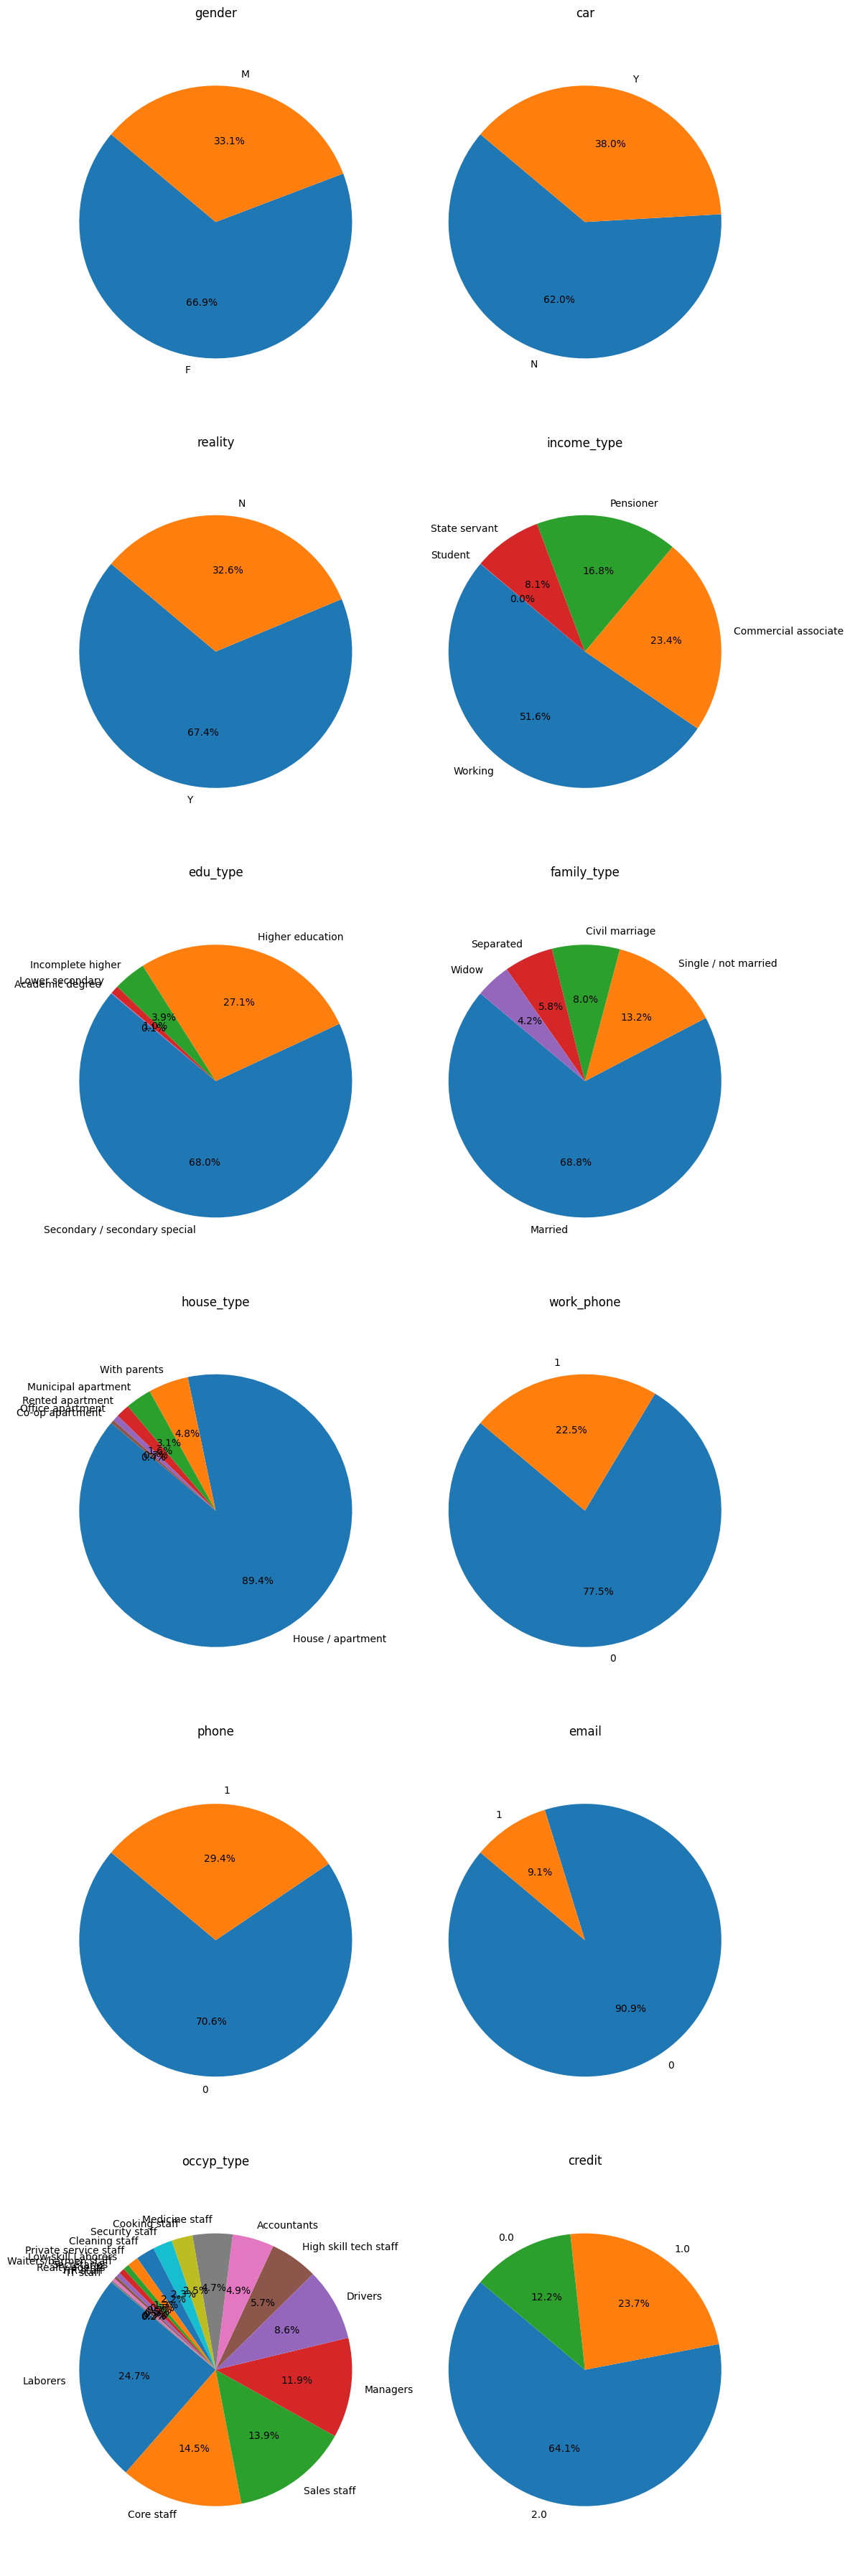

In [ ]:
#categorical + label 의 value 분포
num_rows = len(categorical + label) // 2 + len(categorical + label) % 2
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
for idx, feature in enumerate(categorical + label):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    category_counts = df[feature].value_counts()
    ax.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'{feature}')
    ax.axis('equal')
plt.tight_layout()
plt.show()

##### 설명

위에서 확인 가능한 정보는 다음과 같습니다.
- gender는 여성이 남성보다 많습니다.
- car는 소유한 사람보다 소유하지 않은 사람이 많습니다.
- reality는 소유한 사람보다 소유하지 않은 사람이 많습니다.
- income_type은 Working이 과반수입니다. Student가 극소수 존재합니다.
- edu_type은 Secondary / secondary special이 과반수입니다. Academic degree가 극소수 존재합니다.
- family_type은 Married가 과반수입니다.
- house_type은 House / apartment의 수가 압도적입니다.
- work_phone은 소유한 사람보다 소유하지 않은 사람이 많습니다.
- phone은 소유한 사람보다 소유하지 않은 사람이 많습니다.
- email은 대다수의 사람이 가지고 있지 않습니다. (혹은, 기재하지 않았습니다.)
- occyp_type은 비교적 다양하게 분포해있습니다.
- label인 credit의 경우, 신용도가 높은 이용자일 수록 수가 적습니다.

#### 연속형 변수(수치형 변수, numerical feature)의 분포

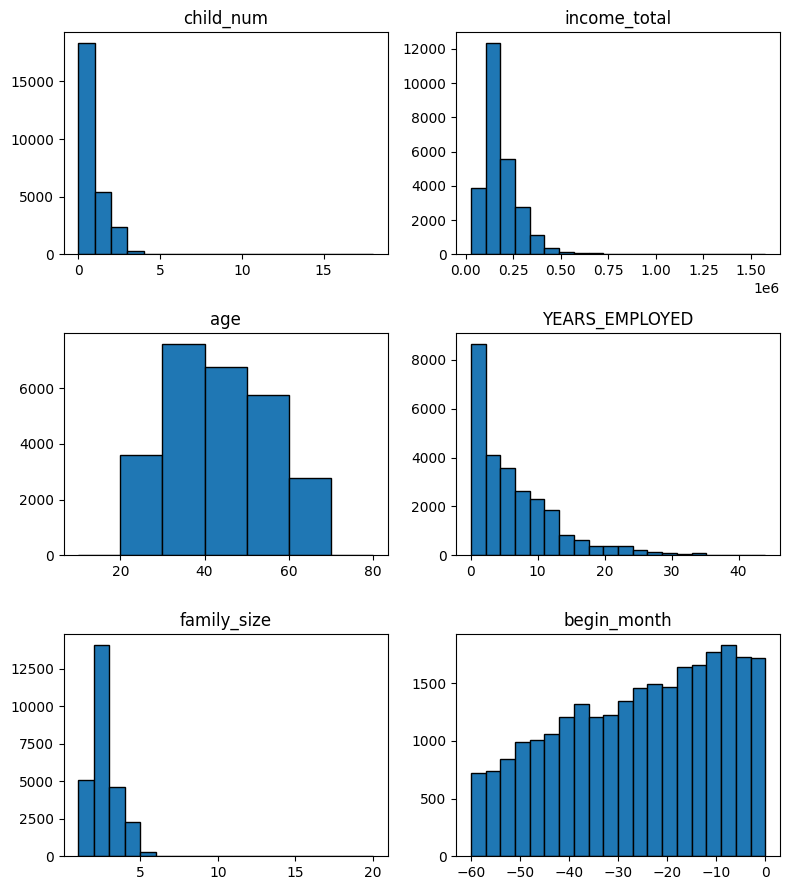

In [ ]:
#numerical feature의 value 분포
num_rows = len(numerical) // 2 + len(numerical) % 2
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 3 * num_rows))


bin_values = {
    'child_num' : range(0,19,1),
    'age': range(10,81,10),
    'family_size' : range(1,21,1)
}

for idx, feature in enumerate(numerical):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    bins = bin_values.get(feature, 20)
    ax.hist(df[feature], bins=bins, edgecolor='black')
    ax.set_title(f'{feature}')

plt.tight_layout()
plt.show()

##### 설명

위에서 확인 가능한 정보는 다음과 같습니다.
- child_num : 대다수의 사람들이 아이를 가지고 있지 않습니다.
- income_ total : 특정 구간에 다수 분포하며, 이상치가 존재합니다.
- age : 대부분의 이용자는 20대 중후반에서 60대 초중반 사이입니다.
- YEARS_EMPLOYED : 고용기간이 0이거나 짧은 사람이 압도적으로 많습니다.
- family_size : 특정 값에 대부분 분포해있습니다. 이상치가 존재합니다.
- begin_month : 고루 분포해있으며 이용기간이 길수록 이용자의 수가 줄어듭니다.

#### credit에 따른 범주형 변수들의 값 분포

In [ ]:
credit0 = df[df['credit']==0.0]
credit1 = df[df['credit']==1.0]
credit2 = df[df['credit']==2.0]

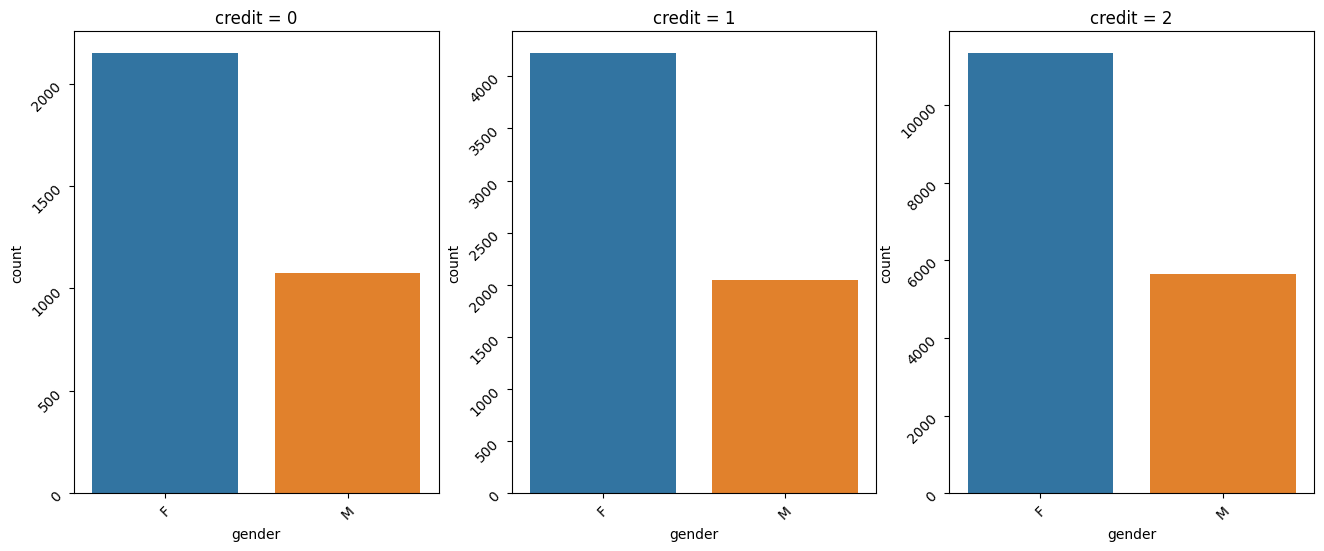

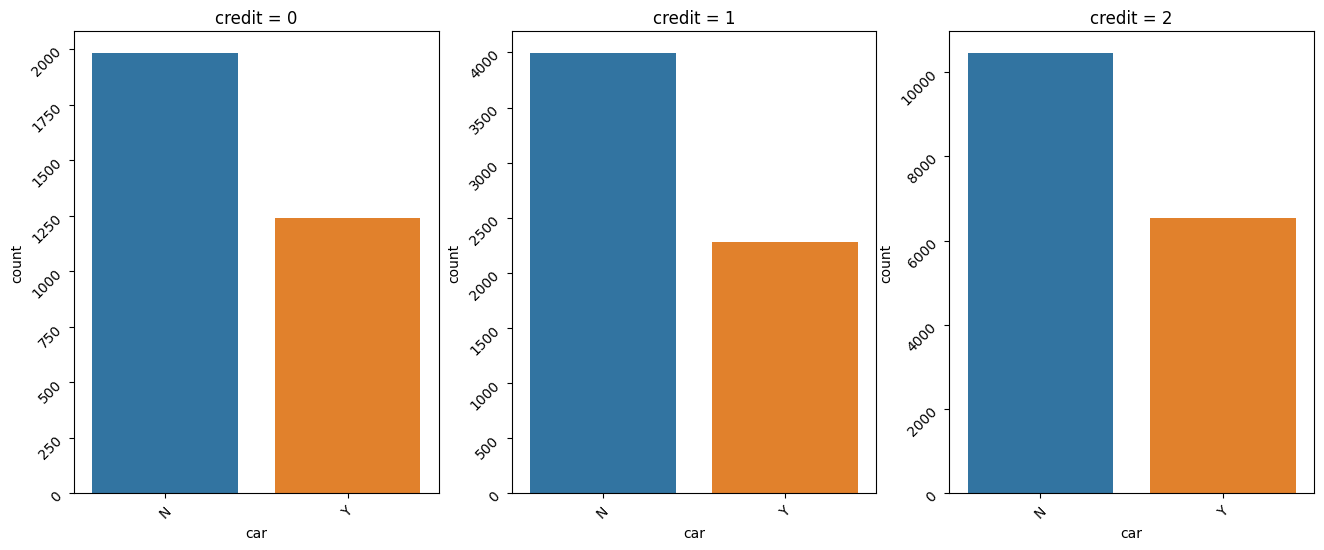

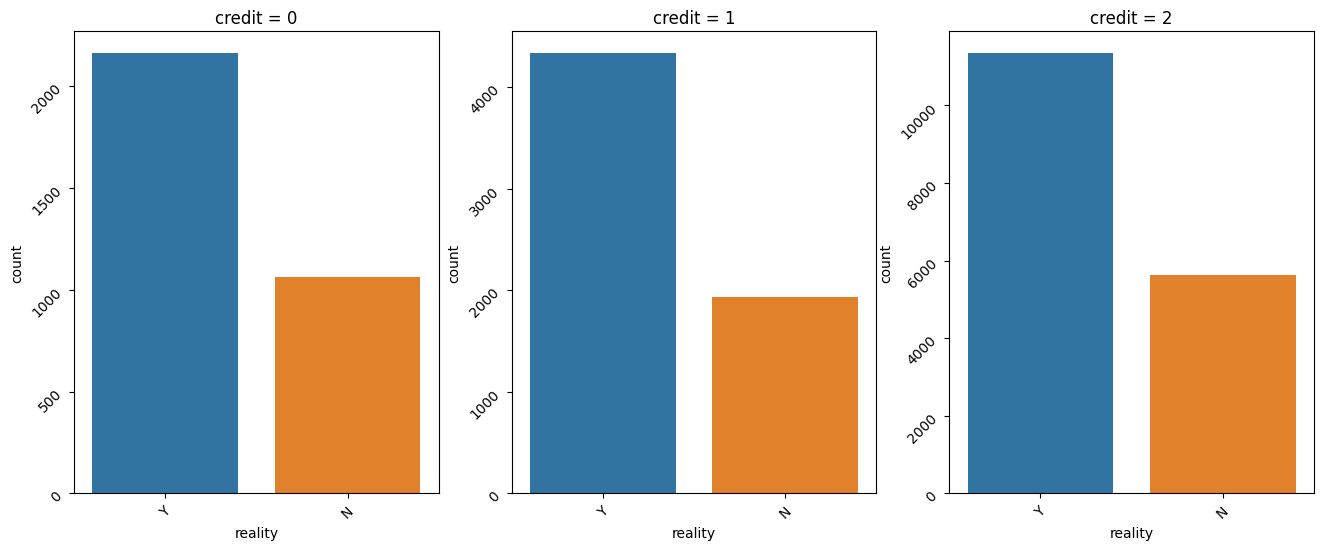

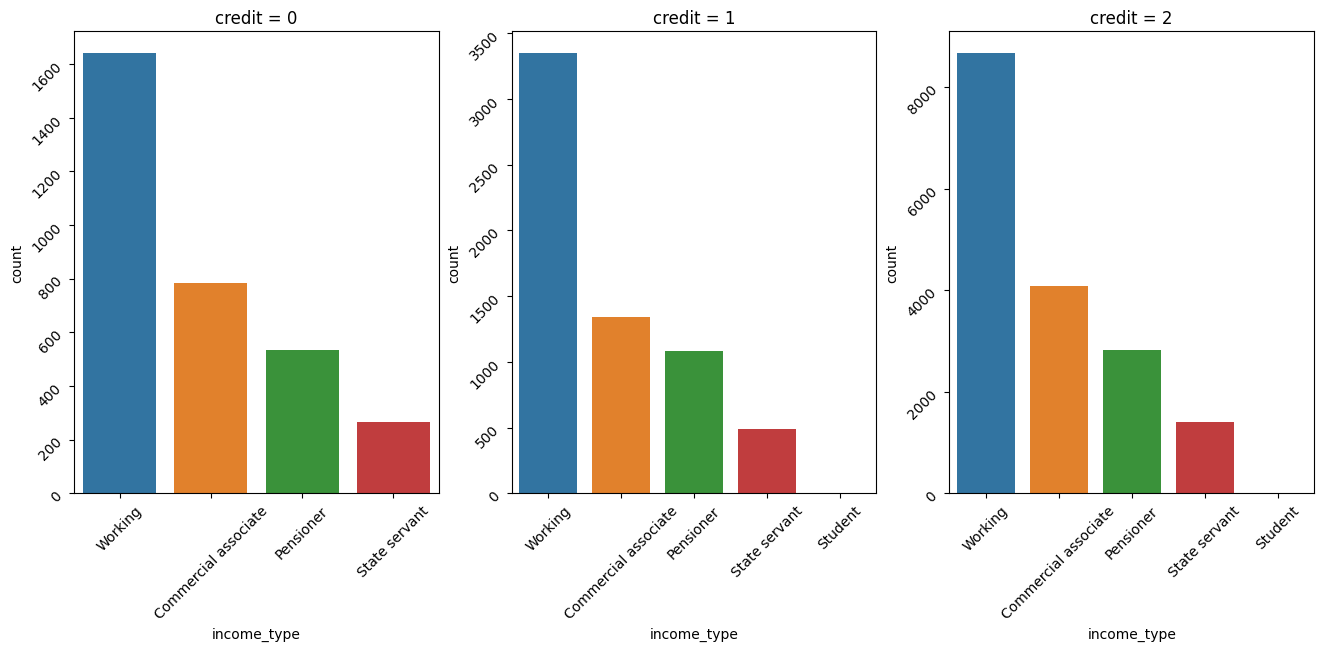

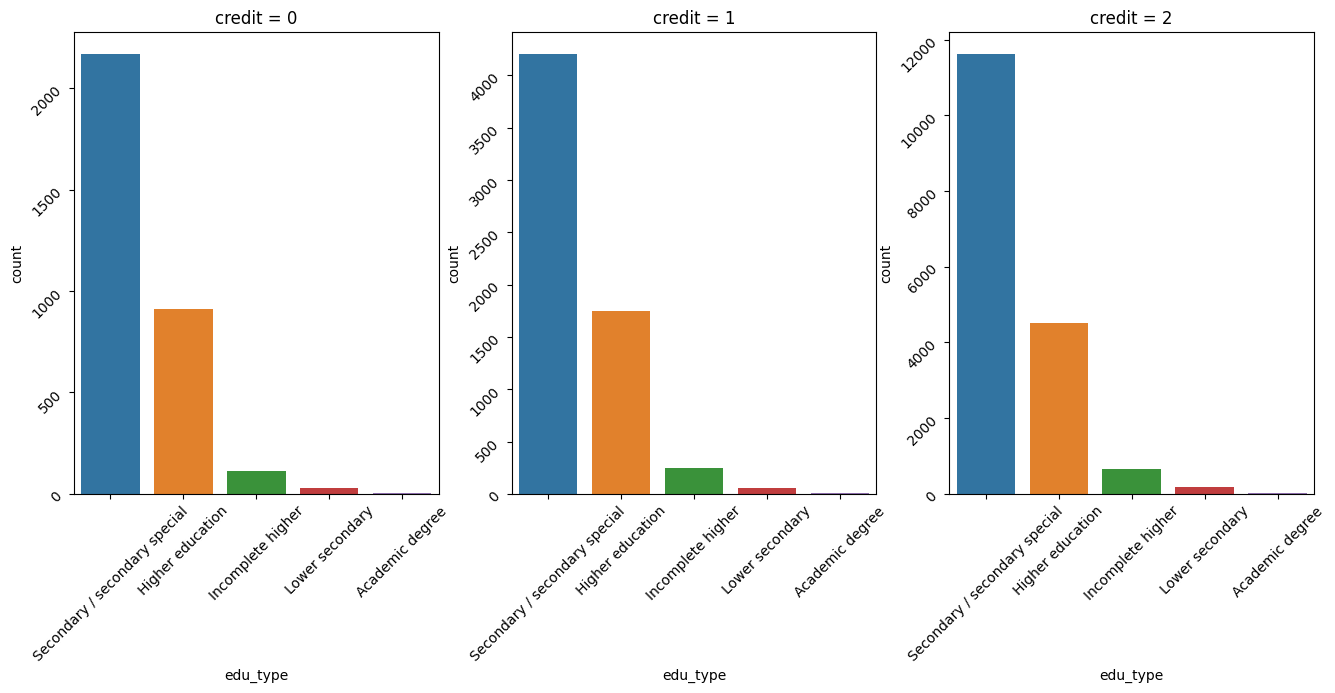

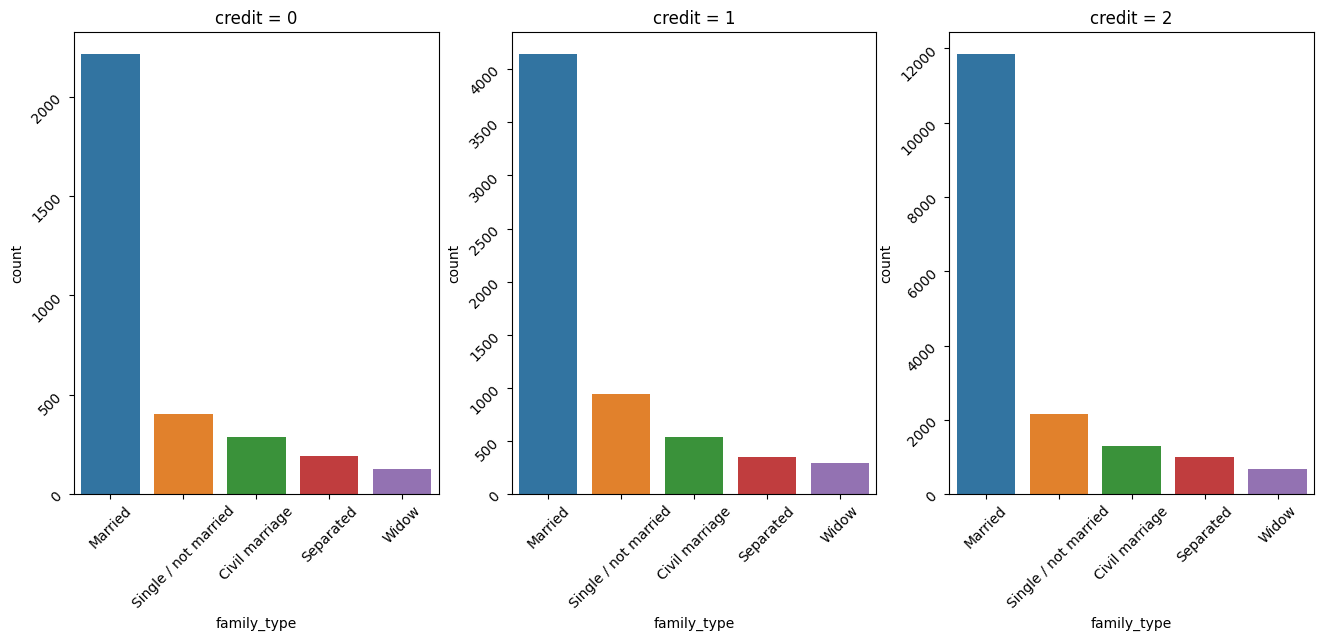

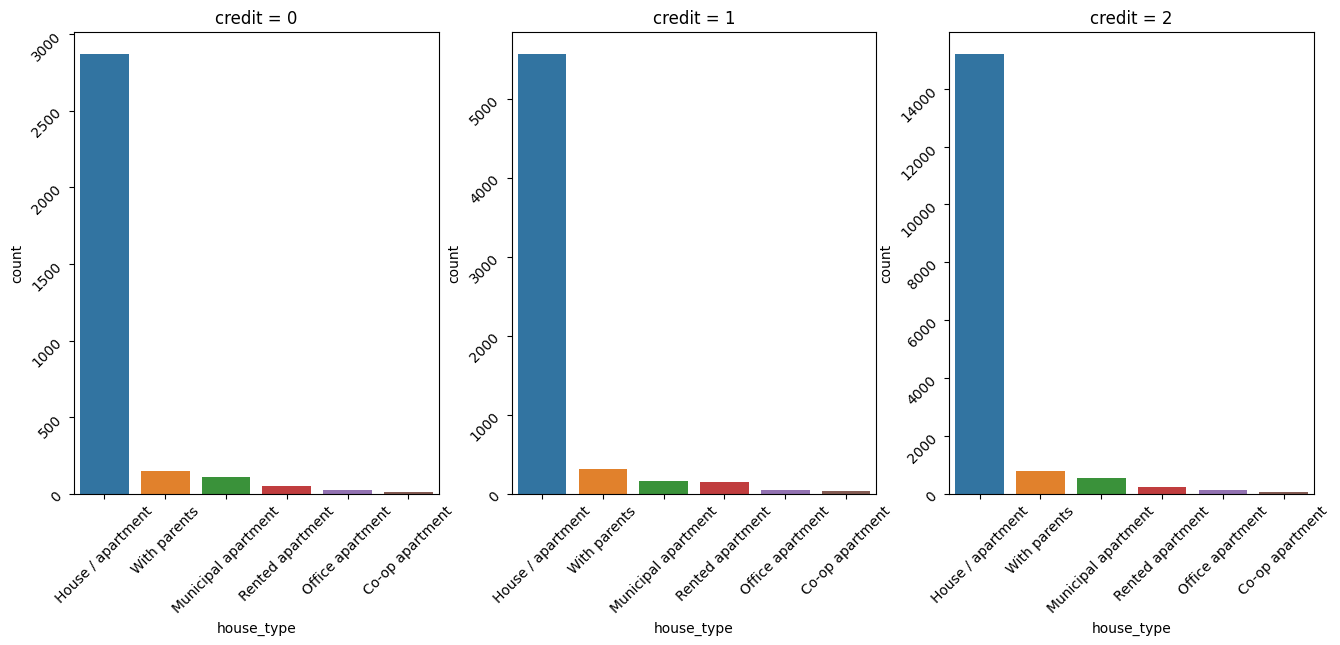

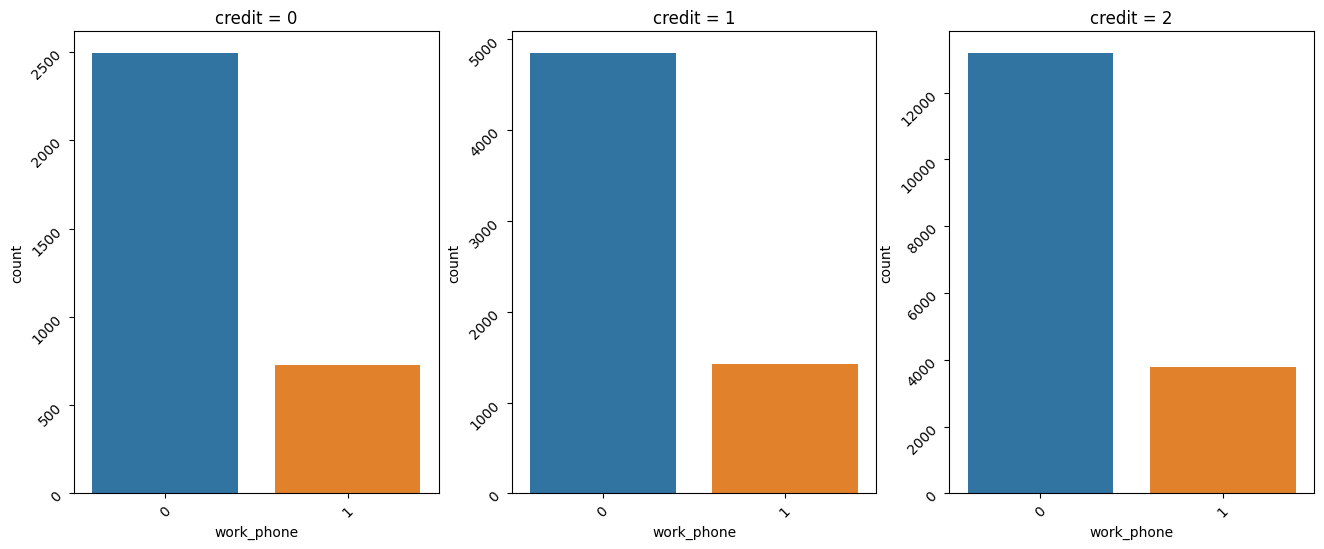

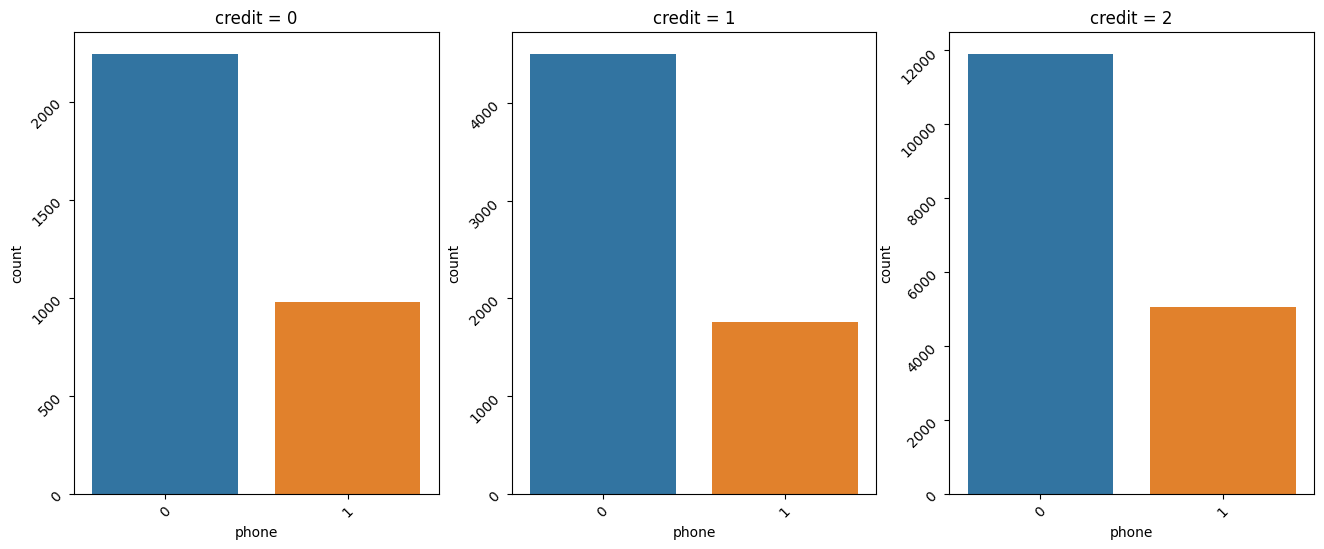

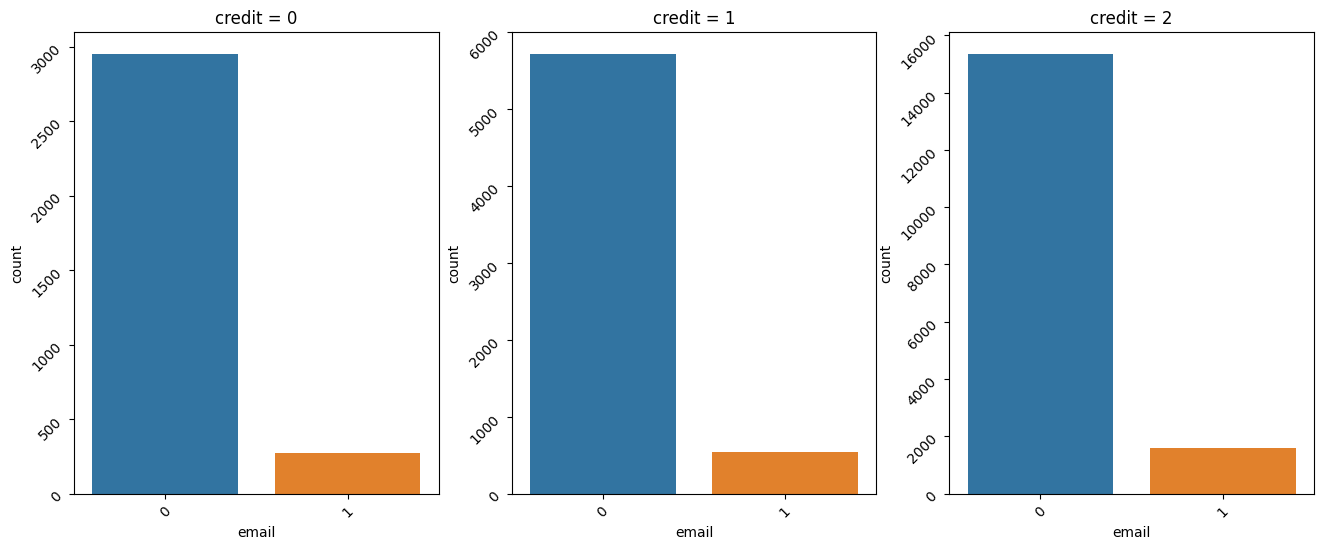

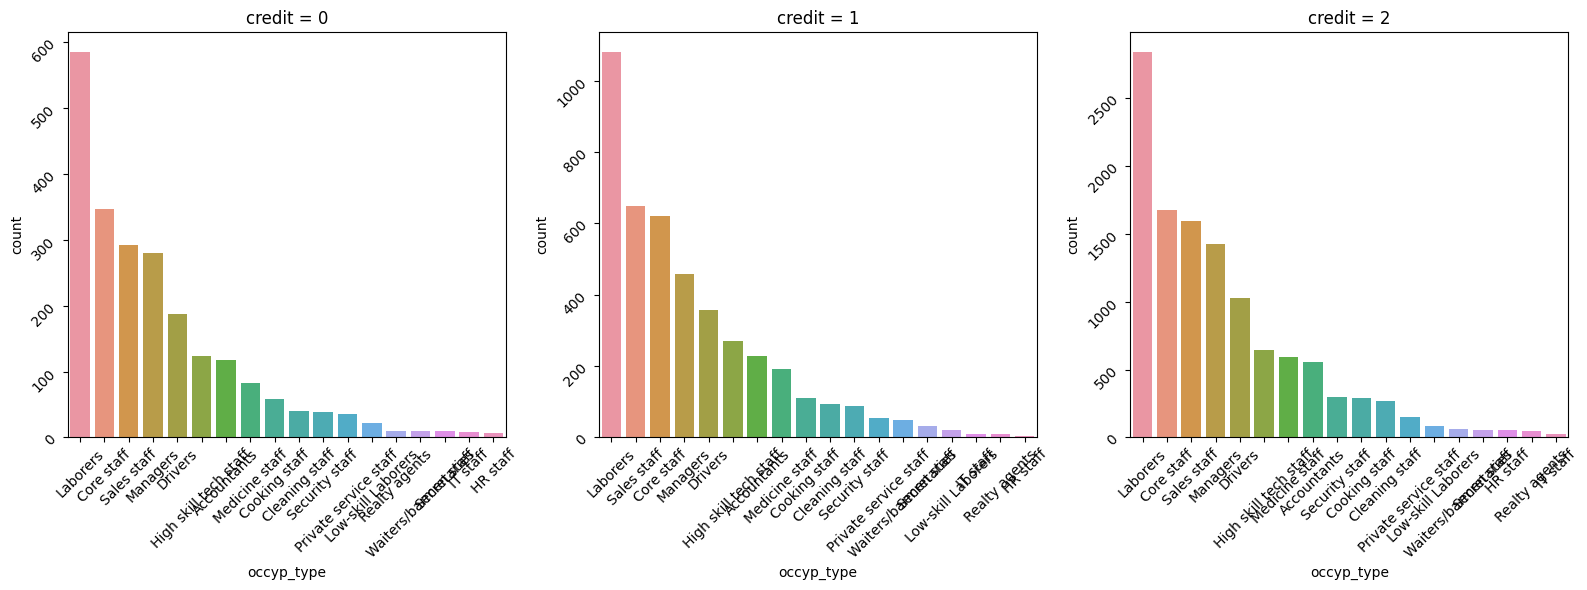

In [ ]:
for column in categorical :
    f, ax = plt.subplots(1, 3, figsize=(16, 6))

    sns.countplot(x = column, data = credit0, ax = ax[0], order = credit0[column].value_counts().index)
    ax[0].set_title('credit = 0')
    ax[0].tick_params(rotation=45)

    sns.countplot(x = column, data = credit1, ax = ax[1], order = credit1[column].value_counts().index)
    ax[1].set_title('credit = 1')
    ax[1].tick_params(rotation=45)

    sns.countplot(x = column, data = credit2, ax = ax[2], order = credit2[column].value_counts().index)
    ax[2].set_title('credit = 2')
    ax[2].tick_params(rotation=45)

plt.tight_layout()
plt.show()

credit=0 그룹에 student가 없다는 사실 외에는 큰 특이사항이 없습니다.

#### 범주형 변수에 따른 credit 평균

참고를 위해 이번에는 반대로 범주형 변수에 따른 credit의 평균을 살펴보겠습니다.

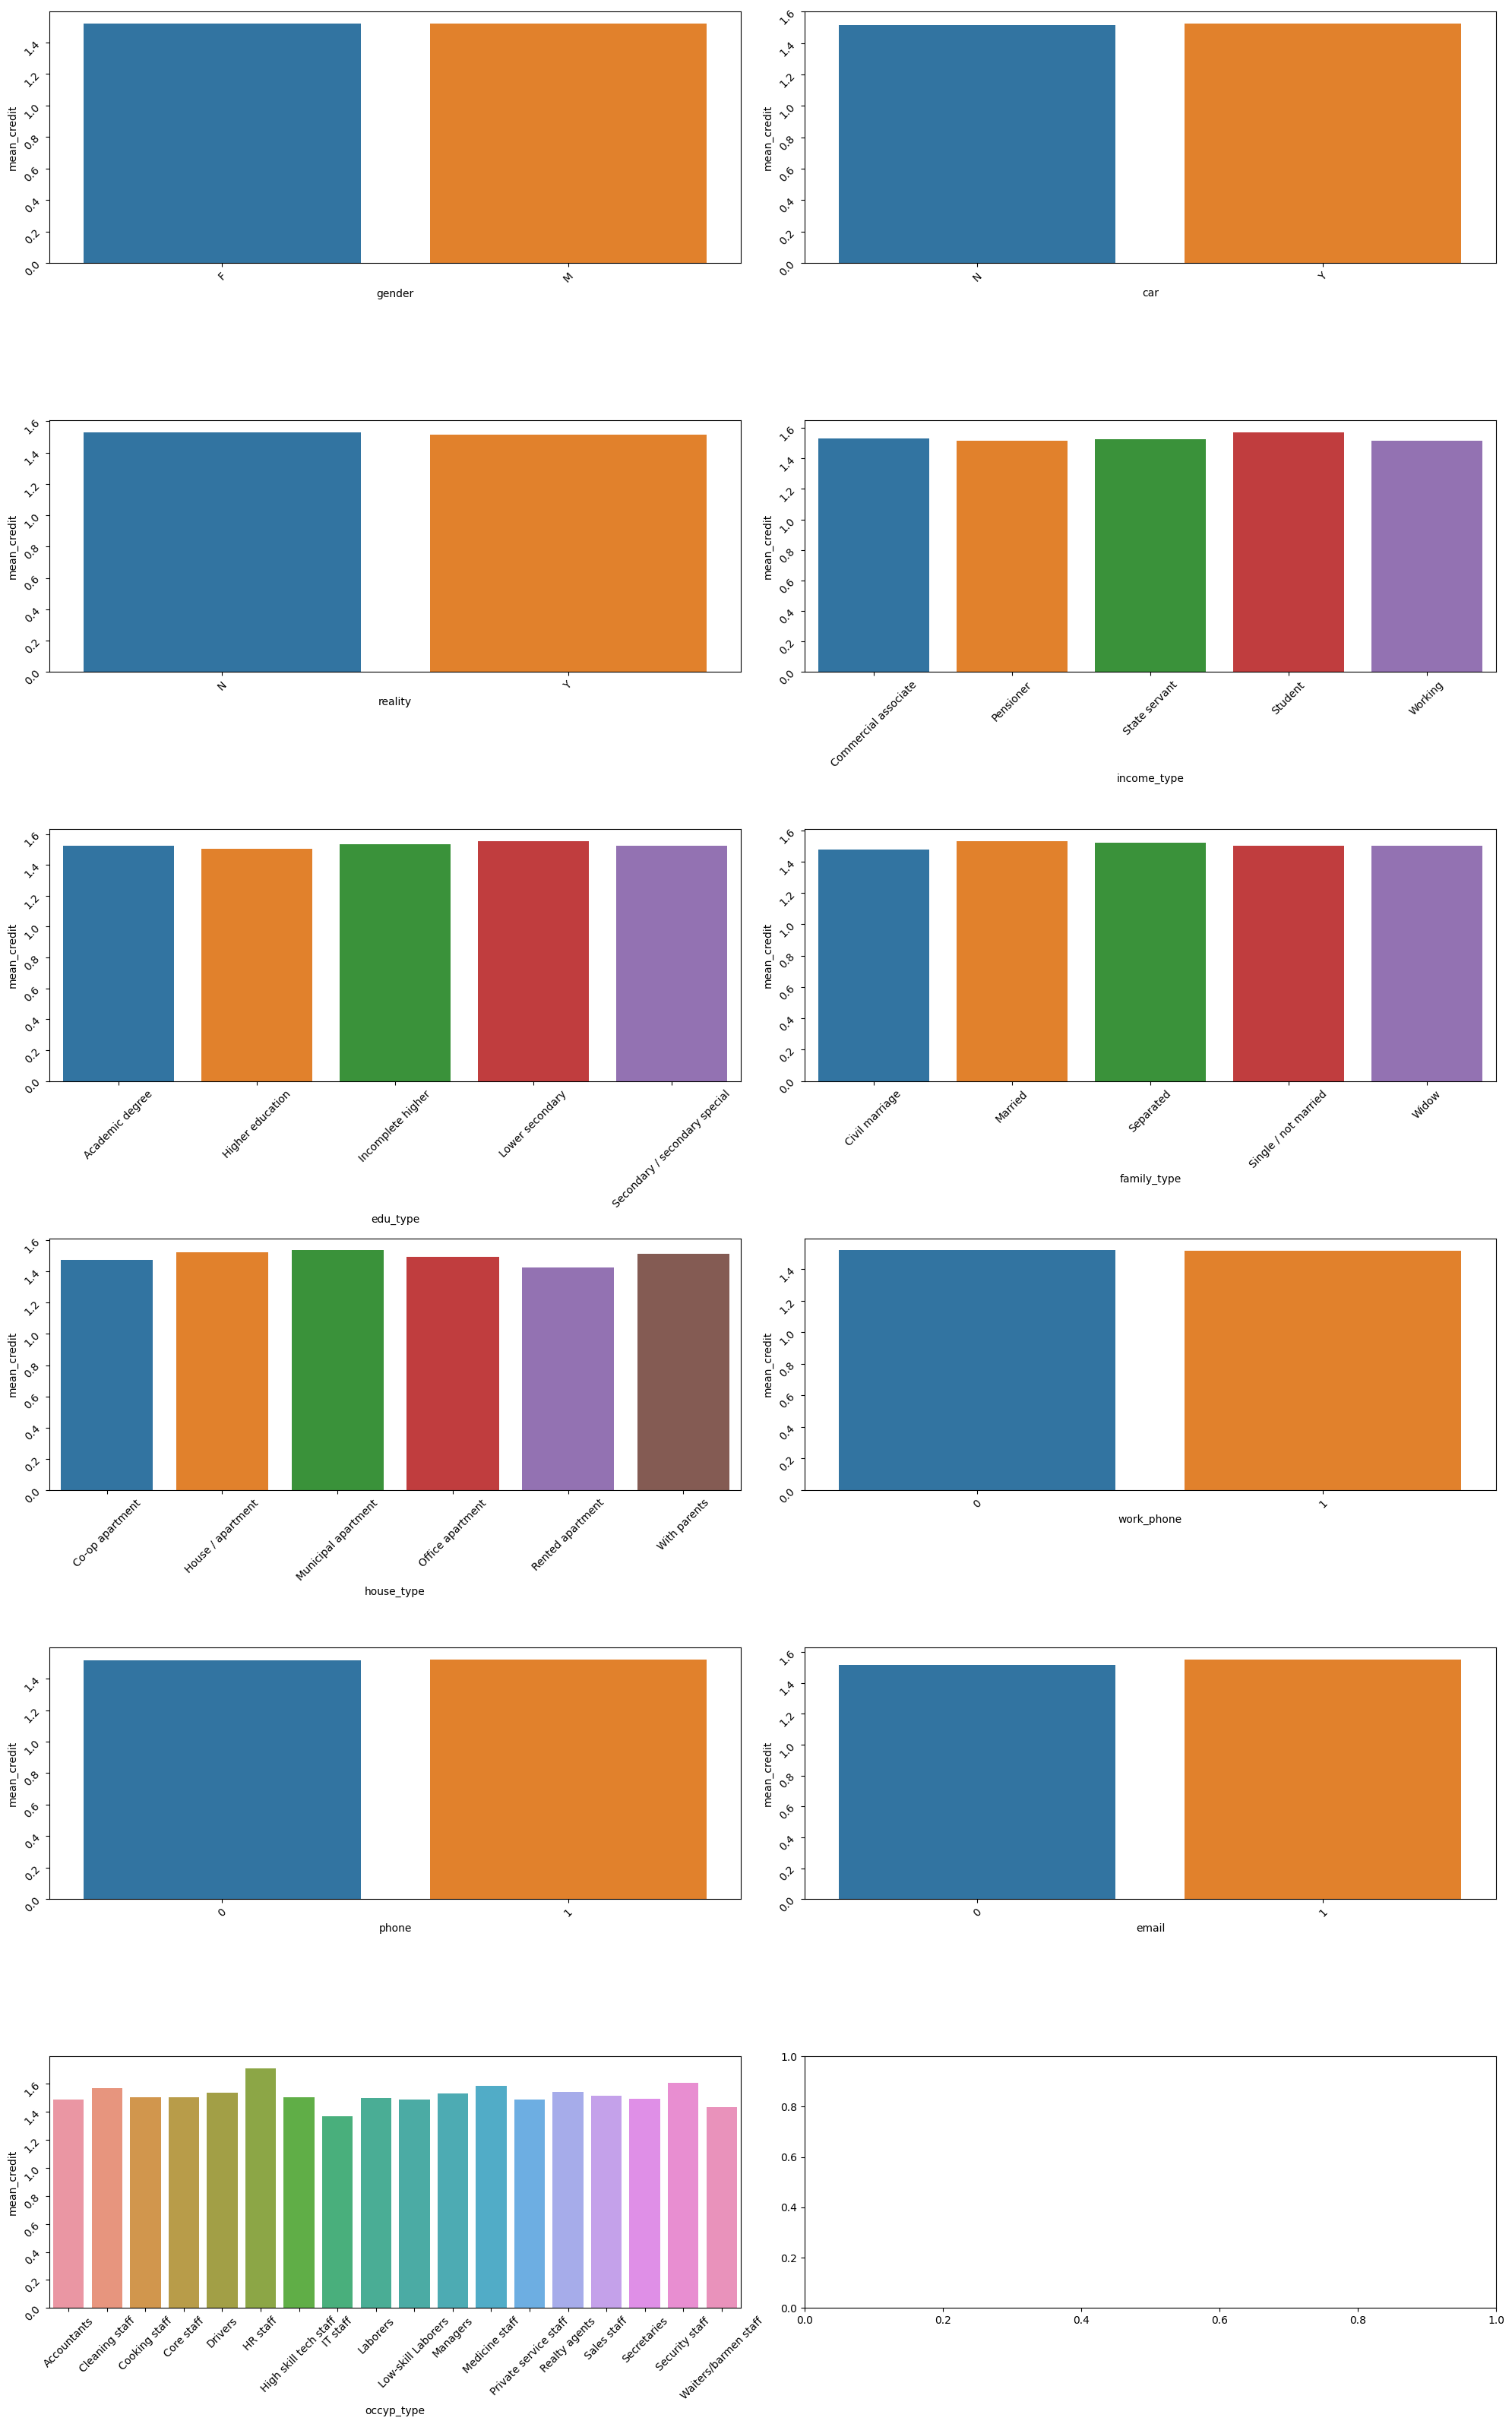

In [ ]:
figsize = (20,32)
fig, axes = plt.subplots((len(categorical)+1)//2, 2, figsize=figsize)
for category in categorical :
    mean_credit = df.groupby(category)['credit'].mean().reset_index()
    mean_credit.rename(columns={'credit': 'mean_credit'}, inplace=True)
    ax = axes[categorical.index(category) // 2, (categorical.index(category) % 2)]
    sns.barplot(data = mean_credit, x = category, y = 'mean_credit', ax = ax)
    ax.tick_params(rotation = 45)

plt.tight_layout()
plt.show()

평균적으로 큰 특이한 지점은 없어보이나, occyp_type에서는 다른 변수에 비해 상대적으로 차이가 있음을 확인할 수 있습니다.

#### credit에 따른 수치형 변수의 value 분포

credit별로 numerical feature의 분포를 살펴보겠습니다.

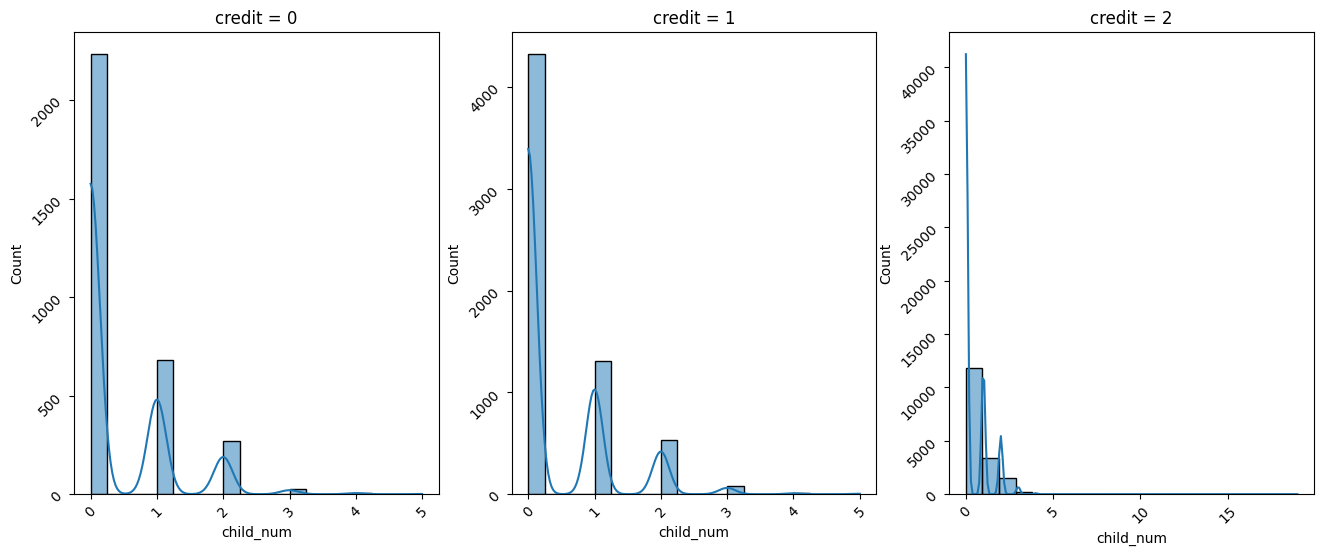

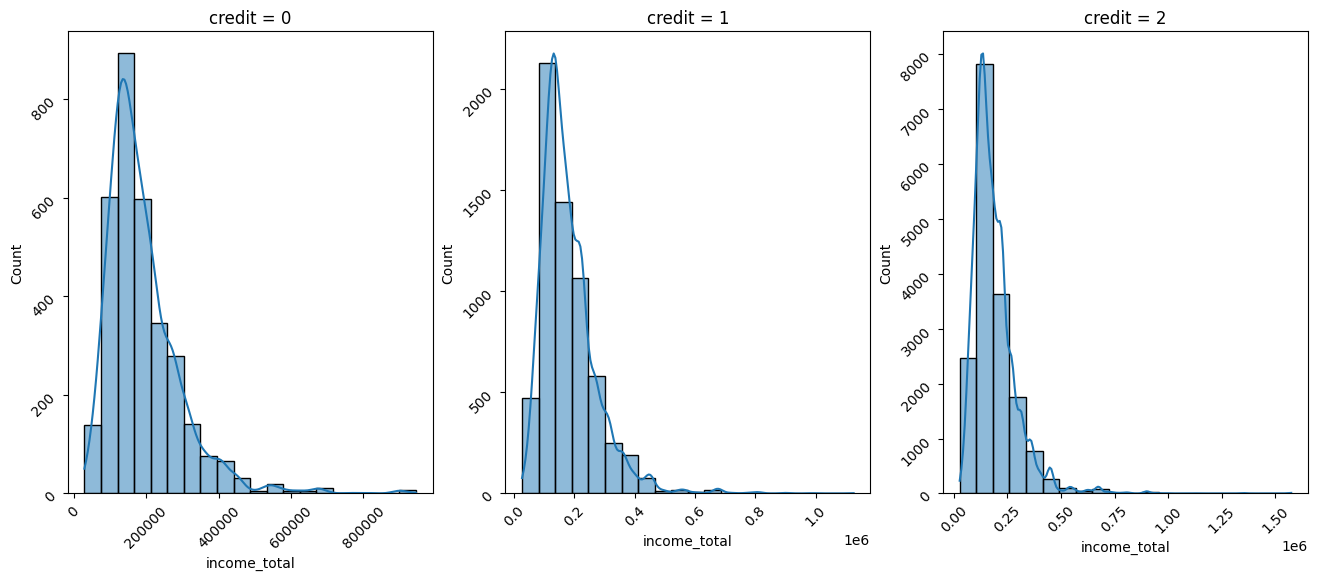

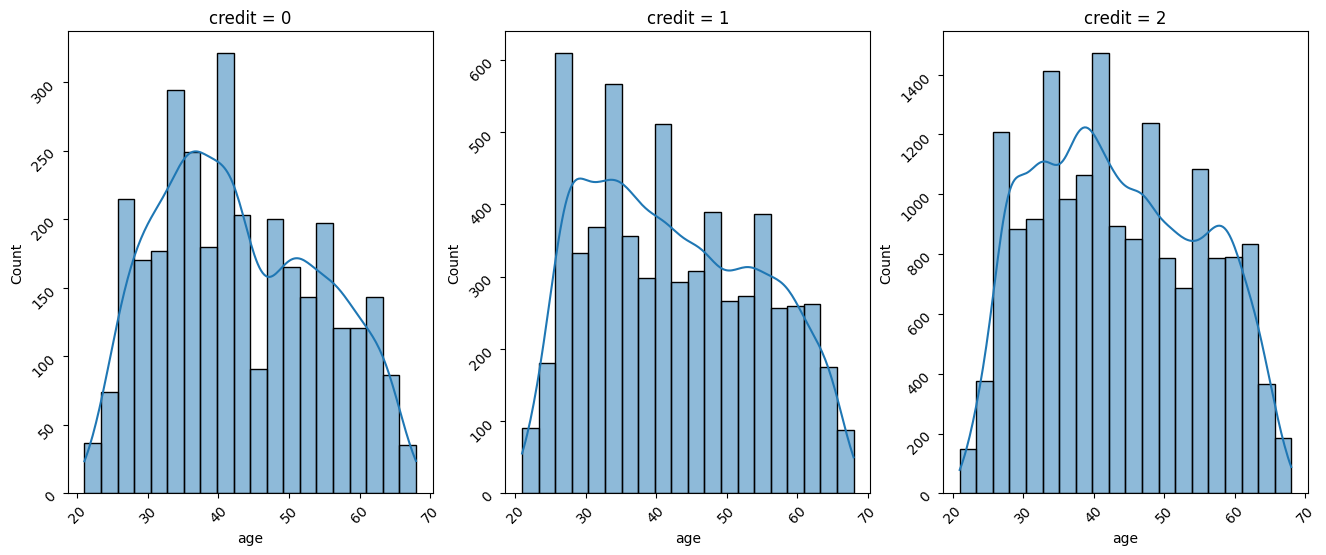

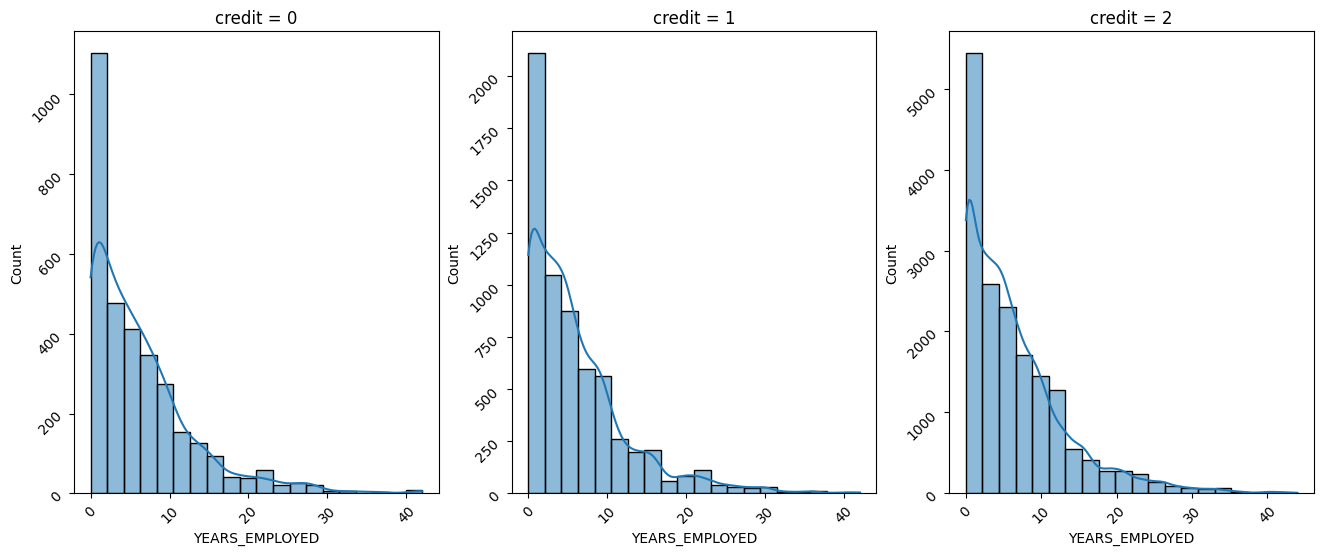

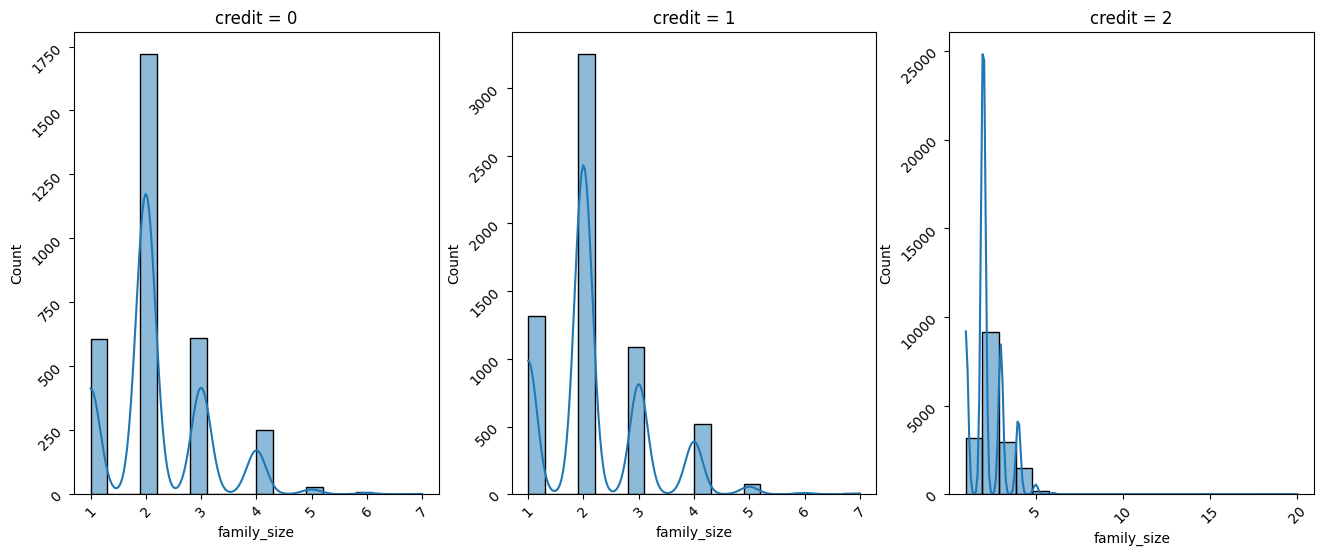

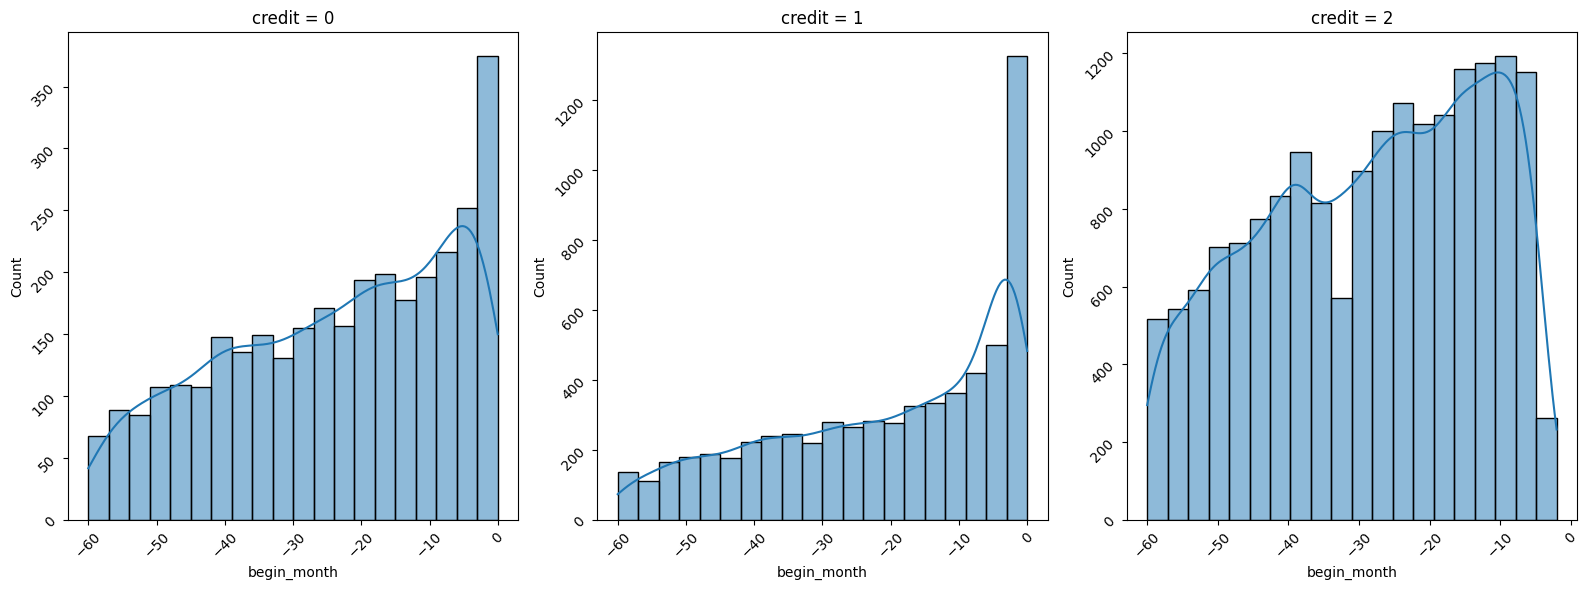

In [ ]:
for column in numerical :
    f, ax = plt.subplots(1, 3, figsize=(16, 6))

    sns.histplot(x = column, kde = True, bins= 20, data = credit0, ax = ax[0])
    ax[0].set_title('credit = 0')
    ax[0].tick_params(rotation=45)

    sns.histplot(x = column, kde = True, bins= 20 ,data = credit1, ax = ax[1])
    ax[1].set_title('credit = 1')
    ax[1].tick_params(rotation=45)

    sns.histplot(x = column, kde = True, bins= 20 , data = credit2, ax = ax[2])
    ax[2].set_title('credit = 2')
    ax[2].tick_params(rotation=45)

plt.tight_layout()
plt.show()

##### 설명

- 대체로 큰 차이를 보이지 않습니다.
- 신용도가 높은 그룹은 신용도가 낮은 그룹에 비해서 30대 중후반~ 40대 초반의 이용자의 비율이 높습니다.
- 신용도가 낮은 그룹에서는 begin_month가 매우 짧은 이용자의 수가 확연히 적습니다.

### 상관계수 확인

dtype이 object가 아닌 feature들의 상관계수를 heatmap으로 확인해보겠습니다.

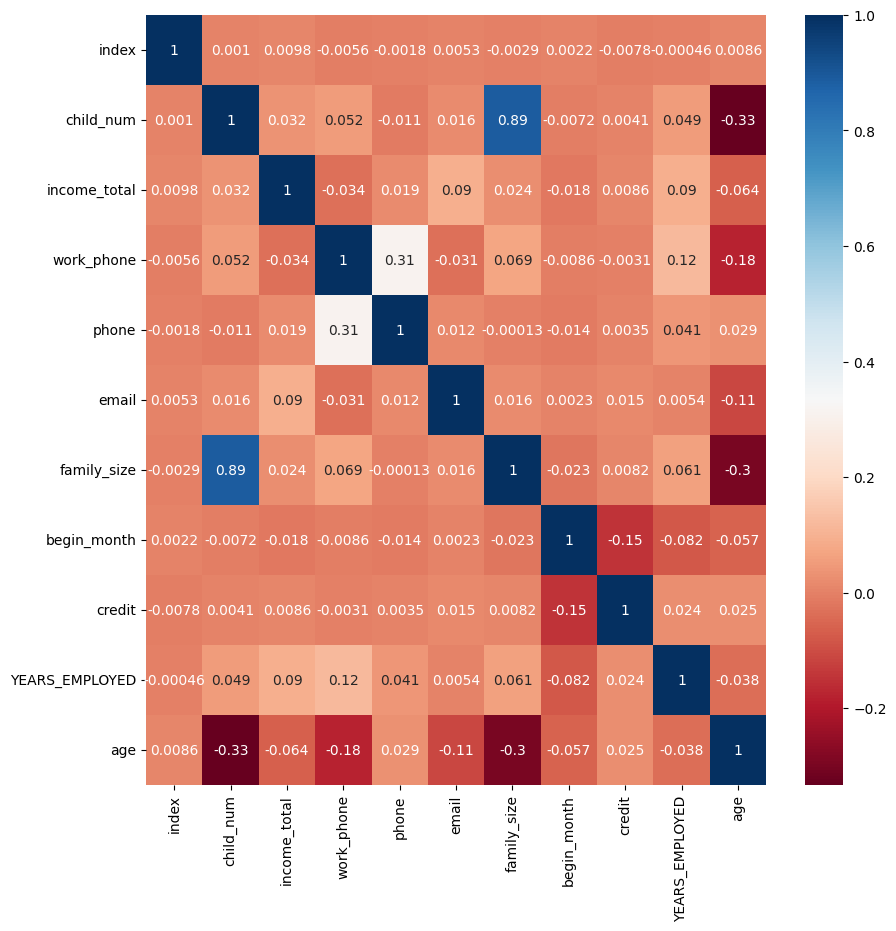

In [ ]:
#FLAG MOBIL, DAYS_EMPLOYED를 처리한 경우
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap ='RdBu', annot= True)
plt.show()

1. DAYS_EMPLOYED, DAYS_BIRTH 를 년단위로 전환, FLAG_MOBIL을 드랍한 데이터
- family_size와 child_num이 매우 강한 상관관계가 있습니다.
- age는 child_num, family_size와 강한 상관관계가 있으며 work_phone과 약한 상관관계가 있습니다.
- phone과 workphone은 강한 상관관계가 있습니다.
- YEARS_EMPLOYED는 work_phone과 약한 상관관계가 있습니다.
- begin_month는 credit과 약한 상관관계가 있습니다.

2. 전처리를 하지 않은 경우 (DAYS_EMPLOYED를 0으로 처리하지 않은 것이 큰 영향을 끼침)
- family_size와 child_num이 큰 상관관계가 있음을 알 수 있다
- DAYS_BIRTH는 child_num, family_size와 상관관계가 있다
- phone과 workphone은 상관관계가 있다
- **DAYS_BIRTH와 DAYS_EMPLOYED는 큰 음의 상관관계가 있다**
- DAYS_EMPLOYED는 work_phone, child_num과 음의 상관관계가 있다

---
---


# Feature Selection / Feature Engineering


 ### **Feature Selection이란?**
> EDA 혹은 모델 성능을 확인하는 과정에서 필요한 feature를 선별하는 절차를 뜻합니다.
    <br>
    <br>
    가령 모델 성능을 비교해보는 과정에서, 'A'라는 feature는 없을 때가 더 성능이 좋아서 빼기로 결정했다면, 이도 feature selection을 수행한 것이지요.

<br>

### **Feature Engineering이란?**
> 그러면 Feature Engineering은 무엇일까요? 간혹 결측치, 중복값, 이상치, 데이터 편향 등의 이유로 feature selection만으로는 적절한 모델 성능을 기대하기 어려울 때가 있습니다.
    <br>
    <br>
    이럴 때 feature를 조작하는 것을 feature engineering이라고 합니다.  결측치를 특정 값으로 채워줄 수도 있고, 결측치가 있는 행/열을 없애줄 수도 있죠.
    <br>
    앞서 EDA에서 특정 feature끼리 결합해서 새로운 feature를 만드는 것도 모두 이에 해당됩니다.
    <br>
    주어진 feature만으로는 성능이 더이상 오르지 않는다면, 새로운 파생변수를 만드는 것도 고려해보세요!


# 다시 데이터 불러오기

위의 EDA 내용을 참고하여, 모델이 학습하기 위해 필요한 데이터 핸들링을 진행하겠습니다.

In [ ]:
df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

## 불필요한 feature 삭제

In [ ]:
df = df.drop(['FLAG_MOBIL', 'index'], axis=1)
test_df = test_df.drop(['FLAG_MOBIL', 'index'], axis=1)

##### 설명

* 'FLAG_MOBIL' : 모든 데이터에서 1로 동일한 값을 가지기 때문에, 변수 간 관계 파악에 도움이 되지 않습니다.
* 'index' : 모든 데이터에서 서로 다른 값을 가지며, 특정 기준에 의한 값이 아닌 단순히 행 번호를  나타내므로, 마찬가지로 변수 간 관계 파악에 도움이 되지 않습니다.

## 결측치 처리: occyp_type

In [ ]:
df['occyp_type'] = df['occyp_type'].fillna("Unknown")
test_df['occyp_type'] = test_df['occyp_type'].fillna("Unknown")

##### 설명

데이터의 수집 배경을 알 수 없어서, 가입 시 고객으로부터 입력받은 개인정보라고 가정하고 접근했습니다.
<br>
이 때 직업을 미기입한 경우 결측치로 나타난다고 유추할 수 있습니다.
<br>
<br>
결측치가 데이터 손실이 아닌 의도된 것이라면, 이를 'Unknown'으로 일괄적으로 채워서, 하나의 카테고리로 인식하도록 합니다.

## 파생변수: ID

In [ ]:
add_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'occyp_type', 'work_phone', 'email', 'DAYS_BIRTH', 'child_num', 'DAYS_EMPLOYED']

df['ID'] = df[add_columns].astype(str).apply(lambda x: '_'.join(x), axis=1)
test_df['ID'] = test_df[add_columns].astype(str).apply(lambda x: '_'.join(x), axis=1)

##### 설명

먼저 drop한 'index', 'FLAG_MOBIL'을 제외하면, 'income_total', 'phone', 'family_size', 'begin_month', 'credit' 외의 모든 변수를 문자열로 더해주었습니다.
<br>
- 이 때 각각의 데이터(row)는 기본적으로는 고유한 값을 가지게 되며, 겹치는 ID값은 동일인물로 식별되도록 하였습니다.
<br>
- 가입 시기('begin_month')에 따라 수입 수준('income_total'), 가족구성원 수('family_size') 등의 정보는 변동될 수 있다고 가정했습니다.
<br>
- credit은 예측해야 하는 y값이기 때문에 제외되었습니다.

## 이상치 처리: 'DAYS_EMPLOYED'

In [ ]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else x)
test_df['DAYS_EMPLOYED'] = test_df['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else x)

##### 설명

근무일수('DAYS_EMPLOYED')는 시작일을 기준으로 경과된 일자만큼의 음수값을 지닙니다. 하지만 양수인 데이터가 있는데, 이들은 이상치로 간주하여, 모두 0으로 처리합니다.


## 이상치 처리: 'child_num'

In [ ]:
df['child_num'].value_counts(normalize=True)

0    0.69
1    0.20
2    0.09
3    0.01
4    0.00
5    0.00
14   0.00
7    0.00
19   0.00
Name: child_num, dtype: float64

In [ ]:
df['child_num'] = df['child_num'].apply(lambda x: 3 if x >= 3 else x)
test_df['child_num'] = df['child_num'].apply(lambda x: 3 if x >= 3 else x)

##### 설명

- 'child_num' == 4인 구간부터는 데이터 내 점유율이 0.17% 이하 수준으로 급격히 떨어지는 것으로 보아 이를 이상치로 판단하고 모두 3으로 값을 조정해주었습니다.
- 다만, 동일한 유형의 이상치는 중요한 특징이 될 것으로 추정하여 파생변수 'ID' 생성 이후에 해당 feature에서 이상치 처리를 진행했습니다.


## 이상치 처리: 'family_size'

In [ ]:
df['family_size'].value_counts(normalize=True)

2.00    0.53
1.00    0.19
3.00    0.18
4.00    0.09
5.00    0.01
6.00    0.00
7.00    0.00
15.00   0.00
9.00    0.00
20.00   0.00
Name: family_size, dtype: float64

In [ ]:
df['family_size'] = df['family_size'].apply(lambda x: 7 if x >= 7 else x)
test_df['family_size'] = df['family_size'].apply(lambda x: 7 if x >= 7 else x)

##### 설명
- 위의 'child_num'의 이상치 처리와 마찬가지로, 7 이상인 값들의 수는 전체의 0.1%가 채 되지 않기 때문에 이상치로 판단하고 7로 값을 조정했습니다.

## feature 핸들링: 음수 -> 절대값

In [ ]:
features = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
for f in features:
    df[f] = df[f].abs()
    test_df[f] = test_df[f].abs()

##### 설명

전반적으로 절대값을 취했을 때 성능이 더 좋았기에, 이를 적용합니다.

## 파생변수: no_work

In [ ]:
df["No_work"] = df["DAYS_BIRTH"] - df['DAYS_EMPLOYED']
test_df["No_work"] = test_df["DAYS_BIRTH"] - test_df['DAYS_EMPLOYED']

##### 설명
출생 이후부터 취업 전까지를 일하지 않은 날로 간주하여 'DAYS_BIRTH'에서 'DAYS_EMPLOYED'를 빼주었습니다.

## 파생변수: 연, 월, 주

In [ ]:
def get_DAY_MONTH_WEEK(df, feature):
    df[f'{feature}(year)'] = df[feature] // 365 # 연 정보
    df[f'{feature}(month)'] = (df[feature] % 365) // 30 # 월 정보
    df[f'{feature}(week)'] = ((df[feature] % 365) % 30) // 7 # 일 정보

    return df

##### 설명
'DAYS_BIRTH', 'DAYS_EMPLOYED', 'No_work'의 경우 각각의 값을 일 단위 날짜로 표기했으며, 모델 성능 개선을 위해 각각 연, 월, 주 정보를 담은 파생변수를 생성합니다.

In [ ]:
# train data
df = get_DAY_MONTH_WEEK(df, 'DAYS_BIRTH')
df = get_DAY_MONTH_WEEK(df, 'DAYS_EMPLOYED')
df = get_DAY_MONTH_WEEK(df, 'No_work')

# test data도 똑같이 적용해줍니다.
test_df = get_DAY_MONTH_WEEK(test_df, 'DAYS_BIRTH')
test_df = get_DAY_MONTH_WEEK(test_df, 'DAYS_EMPLOYED')
test_df = get_DAY_MONTH_WEEK(test_df, 'No_work')

In [ ]:
# 변수 생성이 잘 되었는지 확인합니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                26457 non-null  object 
 1   car                   26457 non-null  object 
 2   reality               26457 non-null  object 
 3   child_num             26457 non-null  int64  
 4   income_total          26457 non-null  float64
 5   income_type           26457 non-null  object 
 6   edu_type              26457 non-null  object 
 7   family_type           26457 non-null  object 
 8   house_type            26457 non-null  object 
 9   DAYS_BIRTH            26457 non-null  int64  
 10  DAYS_EMPLOYED         26457 non-null  int64  
 11  work_phone            26457 non-null  int64  
 12  phone                 26457 non-null  int64  
 13  email                 26457 non-null  int64  
 14  occyp_type            26457 non-null  object 
 15  family_size        

## 파생변수: 'income_year'

In [ ]:
# df['income_year'] = df['income_total'] / 365
# test_df['income_year'] = test_df['income_total'] / 365
df['income_year'] = df['income_total'] / (df['DAYS_EMPLOYED(year)'] + 1e-4)
test_df['income_year'] = test_df['income_total'] / (test_df['DAYS_EMPLOYED(year)'] + 1e-4)

##### 설명

'income_total'을 총 소득으로 보았을 떄, 앞서 만든 파생변수 'DAYS_EMPLOYED(year)'로 이를 나누면 연소득 정보를 얻을 수 있습니다. 다만 값이 무한으로 발산하는 현상을 막기 위해 아주 작은 값(1e-4 == 0.0001)을 분모에 더해주었습니다.

## 파생변수: 'income'

In [ ]:
df['income'] = df['income_total'] / ((df['DAYS_BIRTH'] + df['DAYS_EMPLOYED']))
test_df['income'] = test_df['income_total'] / ((test_df['DAYS_BIRTH'] + test_df['DAYS_EMPLOYED']))

##### 가정
나이가 많으면서 근무일수도 높다면, 소득수준이 더 높을 것이라고 가정하여 접근했습니다.
<br>
<br>
##### 설명
총소득('income_total')을 살아온 일수('DAYS_BIRTH') + 근무일수('DAYS_EMPLOYED')로 나눠주었습니다.


## 파생변수: 'income_family'

In [ ]:
df['income_famliy'] = df['income_total'] / df['family_size']
test_df['income_famliy'] = test_df['income_total'] / test_df['family_size']

##### 가정
가족구성원이 많다면 실질적인 체감소득이 적을 것이라고 가정했습니다.
<br>
<br>

##### 설명
소득은 동일하되 가족구성원 수가 더 많은 경우, 체감소득은 낮아질 것이기 때문에 총소득('income_total')을 가족구성원 수('family_size')로 나눠주었습니다.

## 파생변수: car + email

In [ ]:
df['car'] = df['car'].apply(lambda x: 1 if x == 'Y' else 0)
test_df['car'] = test_df['car'].apply(lambda x: 1 if x =='Y' else 0)

df['car_email'] = df['car'] + df['email']
test_df['car_email'] = test_df['car'] + test_df['email']

##### 설명

'car', 'email' 자체로는 모델 성능에 큰 영향을 끼치지 못했으나, 둘을 더한 파생변수를 사용했을 때는 성능 개선 효과가 있었습니다.

## 붎필요 변수 삭제

In [ ]:
drop_list = ['DAYS_EMPLOYED','DAYS_BIRTH','income_total', 'No_work', 'car', 'email']
df = df.drop(drop_list, axis=1)
test_df = test_df.drop(drop_list, axis=1)

##### 설명
feature와 y의 패턴 및 선형관계는 모델로 하여금 더 강건한 예측을 할 수 있게 돕지만, feature와 feature 간의 지나치게 짙은 패턴은 오히려 성능을 저해시키는 요소가 되곤 합니다.
<br>
이를 **다중공선성**이라고 하는데, feature들끼리의 연관성이 높아지면 모델이 학습하면서 해당 feature에 이목이 쏠려서 다른 중요한 feature를 놓치게 됩니다.
<br>
따라서 feature selection 간에는 비록 원래부터 존재했던 feature일지라도 성격이 유사한 경우 하나만 가져가는 것을 고려해볼 수도 있습니다.
<br>
여기서는 파생변수를 만들면서 사용되었던 feature들을 삭제합니다.

# 전처리

<< 설명 보충 필요 >>

## 타입캐스팅

In [ ]:
df['credit'] = df['credit'].astype(int)

## Custom Encoding: edu_type

In [ ]:
edu_type = {
    'Lower secondary' : 1, # 중등과정 이하
    'Secondary / secondary special' : 2, # 중등과정
    'Incomplete higher' : 3, # 고등과정 중퇴
    'Higher education' : 4, # 고등과정
    'Academic degree' : 5 # 학사학위
}

In [ ]:
df['edu_type'] = df['edu_type'].apply(lambda x: edu_type[x])
test_df['edu_type'] = test_df['edu_type'].apply(lambda x: edu_type[x])

##### 설명
- 'edu_type'은 최종학력으로 인식하고 대소관계가 있다고 판단하여 별도의 Ordinal Encoding을 진행했습니다.

## train validation split

In [ ]:
X_data = df.drop('credit', axis=1)
y_data = df['credit']

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data,
                                                  test_size=0.001,
                                                  random_state=777,
                                                  stratify=y_data
                                                  )

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((26430, 26), (27, 26), (26430,), (27,))

## StandardScaler

In [ ]:
except_list = ['child_num', 'edu_type', 'work_phone', 'phone', 'family_size', 'car_email']

numerical_columns = X_train.dtypes[X_train.dtypes != 'object'].index.tolist()
numerical_columns = [feature for feature in numerical_columns if not feature in except_list]
numerical_columns

['begin_month',
 'DAYS_BIRTH(year)',
 'DAYS_BIRTH(month)',
 'DAYS_BIRTH(week)',
 'DAYS_EMPLOYED(year)',
 'DAYS_EMPLOYED(month)',
 'DAYS_EMPLOYED(week)',
 'No_work(year)',
 'No_work(month)',
 'No_work(week)',
 'income_year',
 'income',
 'income_famliy']

In [ ]:
std = StandardScaler()

X_train[numerical_columns] = std.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = std.transform(X_val[numerical_columns])
test_df[numerical_columns] = std.transform(test_df[numerical_columns])

## OrdinalEncoder

In [ ]:
# object열 확인하기
object_columns = X_train.dtypes[X_train.dtypes == "object"].index.tolist()
print(object_columns)

['gender', 'reality', 'income_type', 'family_type', 'house_type', 'occyp_type', 'ID']


In [ ]:
# object열 인코딩하기
orde = OrdinalEncoder(object_columns)
X_train[object_columns] = orde.fit_transform(X_train[object_columns])
X_val[object_columns] = orde.transform(X_val[object_columns])
test_df[object_columns] = orde.transform(test_df[object_columns])

# 모델링: LGBM

In [ ]:
import time, datetime

START = datetime.datetime.now()
# print(f"start: {START.strftime('%H:%M:%S')}")

params_grid = {
    'n_estimators' : [350, 400, 450, 500, 550, 600],
    'boosting_type' : ['gbdt', 'dart'],
    'learning_rate' : [0.005, 0.1, 0.3, 0.5, 0.75, 1.0],
    'max_depth' : list(range(5, 10)) + [-1],
}

grid_cv = GridSearchCV(
    estimator = LGBMClassifier(objective='multiclass', random_state=777),
    param_grid = params_grid,
    scoring = 'accuracy',
    n_jobs = 6,
    cv = 10,
    verbose = 3,
    error_score='raise'
)

global result
result = grid_cv.fit(X_train, y_train)


END = datetime.datetime.now()
print(f"start: {START.strftime('%H:%M:%S')}")
print(f"end: {END.strftime('%H:%M:%S')}")

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
[CV 5/10] END boosting_type=gbdt, learning_rate=0.005, max_depth=5, n_estimators=350;, score=0.692 total time=   1.6s
[CV 8/10] END boosting_type=gbdt, learning_rate=0.005, max_depth=5, n_estimators=350;, score=0.692 total time=   1.6s
[CV 3/10] END boosting_type=gbdt, learning_rate=0.005, max_depth=5, n_estimators=400;, score=0.693 total time=   1.8s
[CV 9/10] END boosting_type=gbdt, learning_rate=0.005, max_depth=5, n_estimators=400;, score=0.694 total time=   1.8s
[CV 6/10] END boosting_type=gbdt, learning_rate=0.005, max_depth=5, n_estimators=450;, score=0.682 total time=   2.0s
[CV 2/10] END boosting_type=gbdt, learning_rate=0.005, max_depth=5, n_estimators=500;, score=0.694 total time=   2.2s
[CV 8/10] END boosting_type=gbdt, learning_rate=0.005, max_depth=5, n_estimators=500;, score=0.692 total time=   2.3s
[CV 4/10] END boosting_type=gbdt, learning_rate=0.005, max_depth=5, n_estimators=550;, score=0.693 total time

In [ ]:
result

# 사후분석

# Submission